# KNN Pipeline V2 (Feature Selection & KNN Regressor Added)

# Pipeline Support & Master Functions

Dataset Analysis begins after 3 cells

In [1]:
# Importing Depedencies
import pandas as pd
import numpy as np
#pip install ucimlrepo in anaconda command line prompt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis, jarque_bera
import seaborn as sns
import matplotlib.pyplot as plt
#pip install lazypredict in anaconda command line prompt
from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#pip install tabulate in anaconda command line prompt 
from tabulate import tabulate

In [2]:
# Support Function

# Data Fetching Function
def get_data(id):
    data=fetch_ucirepo(id=id)
    X=data.data.features
    y=data.data.targets
    df=pd.merge(X, y, left_index=True, right_index=True)
    return df, y.columns[0]

# Missing Values Treatment
def missing_value_treatment(df):
    missing_columns=df.columns[df.isna().any()].tolist()
    numerical_cols=df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols=list(set(df.columns) - set(numerical_cols))

    for i in missing_columns:
        if ((df[i].isna().sum() / len(df)) <= 0.05) and (len(df) > 30000):
            df[i].dropna(inplace=True)
            df.reset_index(inplace=True, drop=True)
        elif (df[i].isna().sum() / len(df)) > 0.8:
            df.drop([i], axis=1, inplace=True)
        else:
            for i in missing_columns:
                if (df[i].dtype!='int64') and (df[i].dtype!='float64'):
                    mode_val = df[i].mode()[0]
                    df[i].fillna(mode_val, inplace=True)

            label_encoders={}
            for col in categorical_cols:
                label_encoders[col]=LabelEncoder()
                df[col]=label_encoders[col].fit_transform(df[col].astype(str))

            imputer=KNNImputer(n_neighbors=5) # No hyperparameter tunning done in this version
            df_imputed=imputer.fit_transform(df)
            df_imputed=pd.DataFrame(df_imputed, columns=df.columns)

            for col in categorical_cols:
                df[col]=label_encoders[col].inverse_transform(df_imputed[col].astype(int))

            #Update numerical columns after imputation
            numerical_imputed_cols=list(set(df.columns)-set(categorical_cols))
            df[numerical_imputed_cols]=df_imputed[numerical_imputed_cols]

    print("Dataset is treated for missing values successfully")

# Duplicate Values Treatment
def duplicate_value_treatment(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True,inplace=True)
    print("Dataset is treated for duplicated values successfully")

# Standardization of Numerical Columns
def data_standardization(df,type):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    if type==1:
        scaler=StandardScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)
    elif type==2:
        scaler = MinMaxScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)

# Categorical Encoding
def cat_encoding(df):
    cat_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype=='object') or (df[i].dtype.name=='category'):
            cat_var.append(i)
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])

# Numerical Summary
def num_summary(df):
    return df.describe()

# Class Balance
def class_balance(df):
    return (df[label_column].value_counts(normalize=True)*100)

# Pick top 5 important numerical features
# Note: We've utilized Random Forest Classifier/Regressor on numerical features to determine feature importance.
# Gini Importance is used. It reflects a feature's contribution to model predictiveness.
# The top 5 features with the highest Gini Importance scores were selected for numerical EDA plots.
def top_5_num_features(df):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    X_train=df[num_var]
    y_train=df[label_column]
    if (y_train.dtype=='int64' or y_train.dtype=='float64'):
        rf=RandomForestRegressor(random_state=123)
        rf.fit(X_train, y_train)
    else:
        rf=RandomForestClassifier(random_state=123)
        rf.fit(X_train, y_train)
    feature_importances=rf.feature_importances_
    feature_importance_df=pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df=feature_importance_df.sort_values(by='Importance', ascending=False)
    top_5_numerical_features = feature_importance_df.head(5)['Feature'].tolist()
    return top_5_numerical_features

# Construct histogram and boxplot of important numerical features
def hist_box_plots(df):
    num_features = top_5_num_features(df)
    for i in num_features:
        print("")
        print(f"Histogram and Box Plot - {i}")
        plt.figure(figsize=(10, 6))

        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        sns.boxplot(df[i], ax=ax_box, color='skyblue')
        sns.histplot(df[i], ax=ax_hist, color='salmon', kde=True)
        ax_box.set(xlabel='')

        plt.title(f'Histogram and Box Plot - {i}')
        plt.xlabel(i)
        plt.ylabel('Density')
        plt.show()

        skewness = skew(df[i])
        kurt = kurtosis(df[i])
        JB, p_val = jarque_bera(df[i])

        print("Skewness:", skewness)
        if skewness < 0:
            print("Left Skewed", '\n')
        elif skewness > 0:
            print("Right Skewed", '\n')
        else:
            print("Center", '\n')

        print("Kurtosis:", kurt)
        if kurt < 3:
            print("Platykurtic", '\n')
        elif kurt > 3:
            print("Leptokurtic", '\n')
        else:
            print("Mesokurtic", '\n')

        print("JB Test for Normality")
        print(JB, p_val)
        if p_val < 0.05:
            print("Distribution is not normal", '\n')
        else:
            print("Distribution is normal", '\n')

# Filter Feature Selection
def filter_info(df):
    feature_df=df.drop([label_column], axis=1)
    plt.figure(figsize=(18,15))
    if ((df[label_column].dtype!='float64') & (df[label_column].dtype!='int64')):
        label_column_enc=LabelEncoder().fit_transform(df[label_column])
        mutual_info=mutual_info_classif(feature_df, label_column_enc,random_state=123)
        df_copy=df.copy()
        df_copy[label_column]=label_column_enc
        sns.heatmap(data=df_copy.corr())
    else:
        label_column_enc=df[label_column]
        mutual_info=mutual_info_regression(feature_df, label_column_enc,random_state=123)
        sns.heatmap(data=df.corr())

    correlation=df.drop(label_column, axis=1).apply(lambda x: np.abs(x.corr(pd.Series(label_column_enc))))
    variance=feature_df.var()

    feature_info_df = pd.DataFrame({
        'Mutual_Information': mutual_info,
        'Correlation': correlation,
        'Variance': variance
    }, index=feature_df.columns)

    # Sort based on mutual information, then correlation, and then variance
    # Variance after standardization is kind of redundant as it has been normalized to 1
    feature_info_df=feature_info_df.sort_values(by=['Mutual_Information','Correlation', 'Variance'], ascending=False)
    print("")
    plt.title('Correlation Heatmap')
    plt.show()
    print("")
    print("Mutual Information & Correlation of Each Feature with Target Feature")
    print (feature_info_df,"\n")
    print("Type features as: 'Feature_name1,Feature_name2,Feature_name3...'","\n")
    feat=input("What features to select? ")
    filter_df=df[list(eval(feat))]
    filter_df[label_column]=df[label_column]
    return filter_df

# Wrapper Selection
def wrapper_selection(df,fs):
    np.random.seed(123)
    print("")
    num=int(input("How many features to select? "))
    if (df[label_column].dtype=='int64' or df[label_column].dtype=='float64'):
        model=KNeighborsRegressor(n_neighbors=5, weights='distance') # No hyperparameter tunning done in this version
    else:
        model=KNeighborsClassifier(n_neighbors=5) # No hyperparameter tunning done in this version
    if fs==1:
        selector=SequentialFeatureSelector(model, n_features_to_select=num, direction="forward")
    elif fs==2:
        selector=SequentialFeatureSelector(model, n_features_to_select=num, direction="backward")
    else:
        raise ValueError("Invalid selector. Choose either 'forward', or 'backward'!")
    selector.fit(df.drop([label_column],axis=1), df[label_column])
    selected_indices=selector.support_
    wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
    print("")
    print(f"Following are the {wrapper_df.shape[1]} features selected based on the given feature selector:")
    print("")
    print(wrapper_df.columns)
    wrapper_df[label_column]=df[label_column]
    return wrapper_df

# PCA
def pca_selection(df):
    pca = PCA(random_state=123)
    pca.fit(df.drop([label_column],axis=1))

    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot variance vs. number of components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained vs. Number of Components')
    plt.grid(True)
    plt.show()

    print("")
    num_components = int(input("Enter the number of components for PCA: "))
    pca = PCA(n_components=num_components)
    pca_df=pca.fit_transform(df.drop([label_column],axis=1))
    pca_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(num_components)])
    pca_df[label_column]=df[label_column]
    return pca_df

def pca_visualization(df):
    print("")
    print("This function assumes that first 2 components explain significant variability in the dataset.")
    print("It then uses PCA to visualize patterns associated with class labels in a 2D plot:")
    pca=PCA(n_components=2,random_state=123)
    pca_transformed=pca.fit_transform(df.drop([label_column],axis=1))

    fig = plt.figure(figsize=(10, 8))

    y=df[label_column]
    classes = np.unique(y)
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    for i, cls in enumerate(classes):
        indices=(y==cls)
        plt.scatter(pca_transformed[indices,0], pca_transformed[indices,1], c=colors[i], label=f'Class {cls}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA 2D Plot with Class Labels')
    plt.legend()
    plt.show()


# Train_Test Split
def data_split(df):
    print("")
    test_size=int(input("What % of data to be left for test? "))/100
    X=df.drop([label_column],axis=1)
    y=df[label_column]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=123)
    return X_train,X_test,y_train,y_test

# CV
def cross_val(df):
    print("")
    k=int(input("How many folds required? "))
    sk_folds=StratifiedKFold(n_splits=k,random_state=123,shuffle=True)
    return sk_folds

# Model Selection
def models(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)
    print(models)

# Model Training
def knn_learn(df,X_train,y_train,X_test):
    np.random.seed(123)
    print("")
    print("1- Classification","2- Regression", sep='\n')
    print("")
    type=int(input("What is the problem type? "))
    k=int(input("What is the value of K? "))
    if type==1:
        knn=KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        return knn
    elif type==2:
        knn=KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
        return knn

def knn_learnCV(df,X_train,y_train,X_test,sk_folds):
    np.random.seed(123)
    print("")
    print("1- Classification","2- Regression", sep='\n')
    type=int(input("What is the problem type? "))
    print("")
    k=int(input("What is the value of K? "))
    if type==1:
        if df[label_column].nunique()==2:
            knn=KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            scoresCV=cross_validate(knn, df.drop([label_column],axis=1),df[label_column],
                                 scoring=['accuracy','roc_auc'],cv=sk_folds)
            scoresCV=pd.DataFrame(scoresCV)
            return scoresCV
        else:
            knn=KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            scoresCV=cross_validate(knn, df.drop([label_column],axis=1),df[label_column],
                                 scoring=['accuracy'],cv=sk_folds)
            scoresCV=pd.DataFrame(scoresCV)
            return scoresCV
    elif type==2:
        knn=KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
        scoresCV=cross_validate(knn, df.drop([label_column],axis=1), df[label_column],
                                 scoring=['neg_mean_absolute_error','r2'],cv=sk_folds)
        scoresCV=pd.DataFrame(scoresCV)
        scoresCV['test_neg_mean_absolute_error']=np.abs(scoresCV['test_neg_mean_absolute_error'])
        return scoresCV

# Model Evaluation
def model_eval_class(knn,X_test,y_test):
    if df[label_column].nunique()==2:
        y_prob=knn.predict_proba(X_test)
        y_pred_test=knn.predict(X_test)
        auc=roc_auc_score(y_test, y_prob[:, 1])
        class_report=classification_report(y_test,y_pred_test,output_dict=True,target_names=df[label_column].unique().tolist())
        df_report=pd.DataFrame(class_report).transpose()
        df_report1=df_report.iloc[0:2]
        df_report2=df_report1.append(pd.Series({'precision': '---','recall': '---','f1-score': '---','support': '---'},
                                           name='---'))
        df_report2=df_report2.append((df_report.iloc[-3:]).iloc[0:1])
        df_report=df_report2.append(pd.Series({'precision': auc,'recall': auc,'f1-score': auc,'support': auc}, name='AUC'))
        return df_report
    else:
        y_prob=knn.predict_proba(X_test)
        y_pred_test=knn.predict(X_test)
        class_report=classification_report(y_test,y_pred_test,output_dict=True,target_names=df[label_column].unique().tolist())
        df_report=pd.DataFrame(class_report).transpose()
        df_report1=df_report.iloc[0:2]
        df_report2=df_report1.append(pd.Series({'precision': '---','recall': '---','f1-score': '---','support': '---'},
                                           name='---'))
        df_report2=df_report2.append((df_report.iloc[-3:]).iloc[0:1])
        return df_report

def model_eval_reg(knn,X_test,y_test):
    y_pred=knn.predict(X_test)
    r2=r2_score(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)

    data={'R^2 Score':[r2],'MAE':[mae],'RMSE':[rmse]}
    df=pd.DataFrame(data)
    return df


def model_eval_classCV(scoresCV):
    if df[label_column].nunique()==2:
        print("")
        print("Cross-Validation Evaluation")
        print("Average CV Accuracy Score: ", np.mean(scoresCV)[2])
        print("Average CV ROC-AUC Score: ", np.mean(scoresCV)[3])
        print("Number of CV Scores used in Average: ", len(scoresCV))
        return scoresCV
    else:
        print("")
        print("Cross-Validation Evaluation")
        print("Average CV Accuracy Score: ", np.mean(scoresCV)[2])
        print("Number of CV Scores used in Average: ", len(scoresCV))
        return scoresCV

def model_eval_regCV(scoresCV):
    print("")
    print("Cross-Validation Evaluation")
    print("Average CV MAE Score: ", np.mean(scoresCV)[2])
    print("Average CV R^2 Score: ", np.mean(scoresCV)[3])
    print("Number of CV Scores used in Average: ", len(scoresCV))
    return scoresCV

In [3]:
# Master Function
def master(data=None,X_train=None, X_test=None, y_train=None, y_test=None,sk_folds=None,knn=None,scoresCV=None):
    print("1- Fetch Data","2- Data Cleaning (Missing & Duplicate Values Treatment)","3- EDA: Numerical Summary",
          "4- EDA: Class Balance(%) (Classification Only)","5- EDA: Histogram & Box Plot of Important Numerical Features",
          "6- Outliers Detection & Treatment","7- Data Transformation (Categorical Encoding & Standardization)",
          "8- Feature Selection","9- PCA Visualization (Classification Only)", "10-  Data Splitting & Cross-Validation",
          "11- Model Selection","12- Model Training(KNN)", "13- Model Evaluation",
          "14- More Functions to be Added",sep='\n')
            
    print("")
    sr=int(input("What do you want to do? "))
    
    if sr==1 and data==None:
        print("")
        id=int(input("Please enter the UCI ID "))
        df=get_data(id)
        print("Successfuly Connected to the Data Source")
        return df
    
    elif sr==2:
        if data.isnull().values.any() & data.duplicated().any():
            duplicate_value_treatment(data)
            missing_value_treatment(data)
        elif data.isnull().values.any():
            missing_value_treatment(data)
        elif data.duplicated().any():
            duplicate_value_treatment(data)
        else:
            return "Dataset is Already Clean!"    
    
    elif sr==3:
        return num_summary(data)
    
    elif sr==4:
        return class_balance(data)
    
    elif sr==5:
        hist_box_plots(data)
    
    elif sr==6:
        return "Outlier detection and treatment functionality under progress!"
    
    elif sr==7:
        cat_encoding(data)
        print("")
        print("1- Standard Scaler","2- Min-Max Scaler", sep='\n')
        type=int(input("Which type of Scaler? "))
        data_standardization(data,type)
    
    elif sr==8:
        print("")
        print("1- Filter Methods","2- Wrapper Methods","3- Dimensionality Reduction (PCA)", sep='\n')
        method=int(input("Which type of method? "))
        if method==1:
            print("")
            return filter_info(data)
        elif method==2:
            print("")
            print("1- Forward Selection","2- Backward Selection",
                  "3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)", sep='\n')
            fs=int(input("Which feature selection method to select? "))
            return wrapper_selection(data,fs)
        elif method==3:
            return pca_selection(data)
        else:
            raise ValueError("Invalid method. Choose either 'filter', or 'wrapper'")
    
    elif sr==9:
        pca_visualization(data)
    
    elif sr==10:
        print("")
        print("1- Train-Test Split","2- Stratified Cross-Validation (Classification Only)", sep='\n')
        req=int(input("What is the requirement? "))
        if req==1:
            return data_split(data)
        elif req==2:
            return cross_val(data)
    
    elif sr==11:
        models(X_train, X_test, y_train, y_test)
    
    elif sr==12:
        print("")
        print("1- Non-CV","2- CV", sep='\n')
        req=int(input("What is the requirement? "))
        if req==1:
            return knn_learn(data,X_train,y_train,X_test)
        elif req==2:
            return knn_learnCV(data,X_train,y_train,X_test,sk_folds)
    
    elif sr==13:
        print("")
        print("1- Non-CV","2- CV", sep='\n')
        req=int(input("What is the requirement? "))
        print("")
        print("1- Classification","2- Regression", sep='\n')
        type=int(input("What is the problem type? "))
        if req==1:
            if type==1:
                return model_eval_class(knn,X_test,y_test)
            elif type==2:
                return model_eval_reg(knn,X_test,y_test)
        elif req==2:
            if type==1:
                return model_eval_classCV(scoresCV)
            elif type==2:
                return model_eval_regCV(scoresCV)
    
    else:
        return "Please either select correct option or wait for future updates!"

# Classification Datasets

# Breast Cancer Wisconsin (Diagnostic) Dataset
Source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

### Data Preprocessing & EDA

In [4]:
# Dataset loading (can use pipeline function if dataset is fetched from UCI using uci dataset id)
df=pd.read_csv("Classification.CancerMB.csv")
label_column='diagnosis'
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,nan
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,nan
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,nan
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,nan
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,nan


In [5]:
# Manually drop redundant columns
df=df.drop(["id"],axis=1)
df=df.drop(["Unnamed: 32"],axis=1)

In [6]:
# Data Cleaning
master(df)
# This function first checks for duplicate values and drop them
# Then it imputes categorical missing values with modal value
# Afterwards it uses KNN imputer to impute missing values for numerical variables
# Overall it checks what type of cleaning is required (if any) and acts accordingly!

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 2


'Dataset is Already Clean!'

In [7]:
# Summary of Numerical Variables
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 3


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,...,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08
std,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,...,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02
min,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,...,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06
25%,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,...,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07
50%,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,...,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08
75%,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,...,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09
max,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,...,36.04,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21


In [8]:
# Class Balance
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 4


B   62.74
M   37.26
Name: diagnosis, dtype: float64

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 5

Histogram and Box Plot - perimeter_worst


<Figure size 720x432 with 0 Axes>

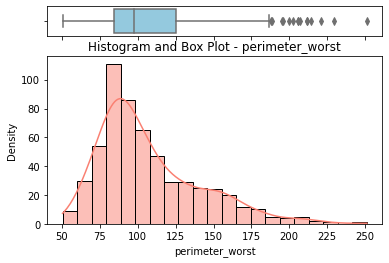

Skewness: 1.1251876208771259
Right Skewed 

Kurtosis: 1.0502426838462862
Platykurtic 

JB Test for Normality
146.21399596125104 0.0
Distribution is not normal 


Histogram and Box Plot - concave points_worst


<Figure size 720x432 with 0 Axes>

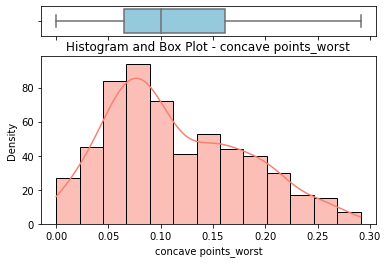

Skewness: 0.4913159397943974
Right Skewed 

Kurtosis: -0.541367070017905
Platykurtic 

JB Test for Normality
29.840344749857664 3.313229111068239e-07
Distribution is not normal 


Histogram and Box Plot - radius_worst


<Figure size 720x432 with 0 Axes>

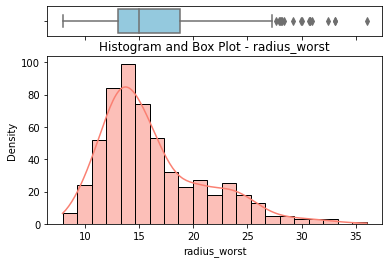

Skewness: 1.1002050372722139
Right Skewed 

Kurtosis: 0.9252876046135072
Platykurtic 

JB Test for Normality
135.0891740572985 0.0
Distribution is not normal 


Histogram and Box Plot - concave points_mean


<Figure size 720x432 with 0 Axes>

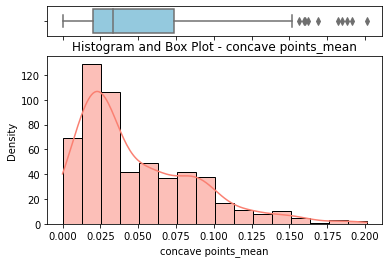

Skewness: 1.1680903481012583
Right Skewed 

Kurtosis: 1.0466802239531967
Platykurtic 

JB Test for Normality
155.36734042008953 0.0
Distribution is not normal 


Histogram and Box Plot - area_worst


<Figure size 720x432 with 0 Axes>

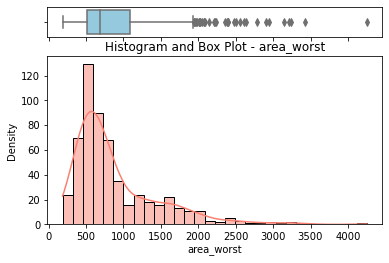

Skewness: 1.8544679916096252
Right Skewed 

Kurtosis: 4.347330804638665
Leptokurtic 

JB Test for Normality
774.20727177989 0.0
Distribution is not normal 



In [9]:
# Histogram & Box Plot of top 5 most significant numerical features
master(df)
# It uses random forest classifier/regressor to determine important features based on feature importance metric

#### EDA Interpretation:

##### Class Imbalance:
There exists a class imbalance where the benign class significantly outweighs the malignant class. In this case, the dataset is skewed towards the benign class. This could lead to models that are better at predicting the majority class but perform poorly on the minority class (malignant) which is in reality the significant class. So during evaluation instead of just looking at overall accuracy, precision, recall, f1-score, and AUC should be given preferance.

---------------------------------------------------------------------------------------------------------------------------
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance. These features are perimeter_worst, concave points_worst, radius_worst, concave points_mean, and area_worst.

##### Perimeter_worst:
This feature refers to the largest perimeter measurement of the detected tumor. Higher value leads to higher possibility of malignant tumor. Its distribution is right-skewed, indicating a concentration of values towards lower perimeters with a tail extending towards higher measurements. The distribution with flatter and wider peak suggests thinner tails but still there are numerous values exceeding upper whisker which indicates the potential existence of outliers at the upper end of the distribution. The non-normal distribution further indicates that the feature's predictive power may be influenced by its skewed nature and outliers.

##### Concave points_worst:
This feature represents the largest number of concave portions in the detected tumor. Higher value leads to higher possibility of malignant tumor. Its distribution is right-skewed but just so slightly, indicating a small concentration of values towards lower perimeters with a slightly extending tail towards higher measurements. The platykurtic distribution suggests thinner tails and there are no extreme values either. The distribution is non-normal but just so slightly as well. Given this nature, the feature can be extremely useful in capturing true patterns of the cancer detection.

##### Radius_worst:
This feature refers to the largest radius measurement of the detected tumor. Higher value leads to higher possibility of advance stage cancer. Its distribution is right-skewed, indicating a concentration of values towards lower perimeters with a tail extending towards higher measurements. The distribution with flatter and wider peak suggests thinner tails but still there are numerous values exceeding upper whisker which indicates the potential existence of outliers at the upper end of the distribution. The non-normal distribution further suggests that the feature's predictive power may be influenced by its skewed nature and outliers.

##### Concave points_mean:
This feature represents the average number of concave portions (average of 3 readings) in the detected tumor. Its distribution is right-skewed, indicating a concentration of values towards lower perimeters with a tail extending towards higher measurements. The distribution with flatter and wider peak suggests thinner tails but still there are numerous values exceeding upper whisker which indicates the potential existence of outliers at the upper end of the distribution. The non-normal distribution further suggests that the feature's predictive power may be influenced by its skewed nature and outliers.

##### Area_worst:
Similar to perimeter_worst and radius_worst, a larger area suggests a larger tumor size, potentially indicating more advanced stages of cancer. Its distribution is right-skewed, indicating a concentration of values towards lower perimeters with a tail extending towards higher measurements. The leptokurtic distribution suggests heavy tails with a lot of extreme values and this is also evident from the box plot where there are numerous values exceeding upper whisker which indicates the potential existence of outliers at the upper end of the distribution. The non-normal distribution further suggests that the feature's predictive power may be influenced by its skewed nature and outliers.

In [10]:
###### Outlier Analysis & Treatment functionality is still under progress!
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 6


'Outlier detection and treatment functionality under progress!'

In [11]:
# Data Transformation
master(df)
# This function first label encode categorical features so that they become numerical (except the target variable)
# Then it uses standard or min-max scaler to standardize all numerical feature (so doesn't apply on target variable)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


### Feature Selection

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 1




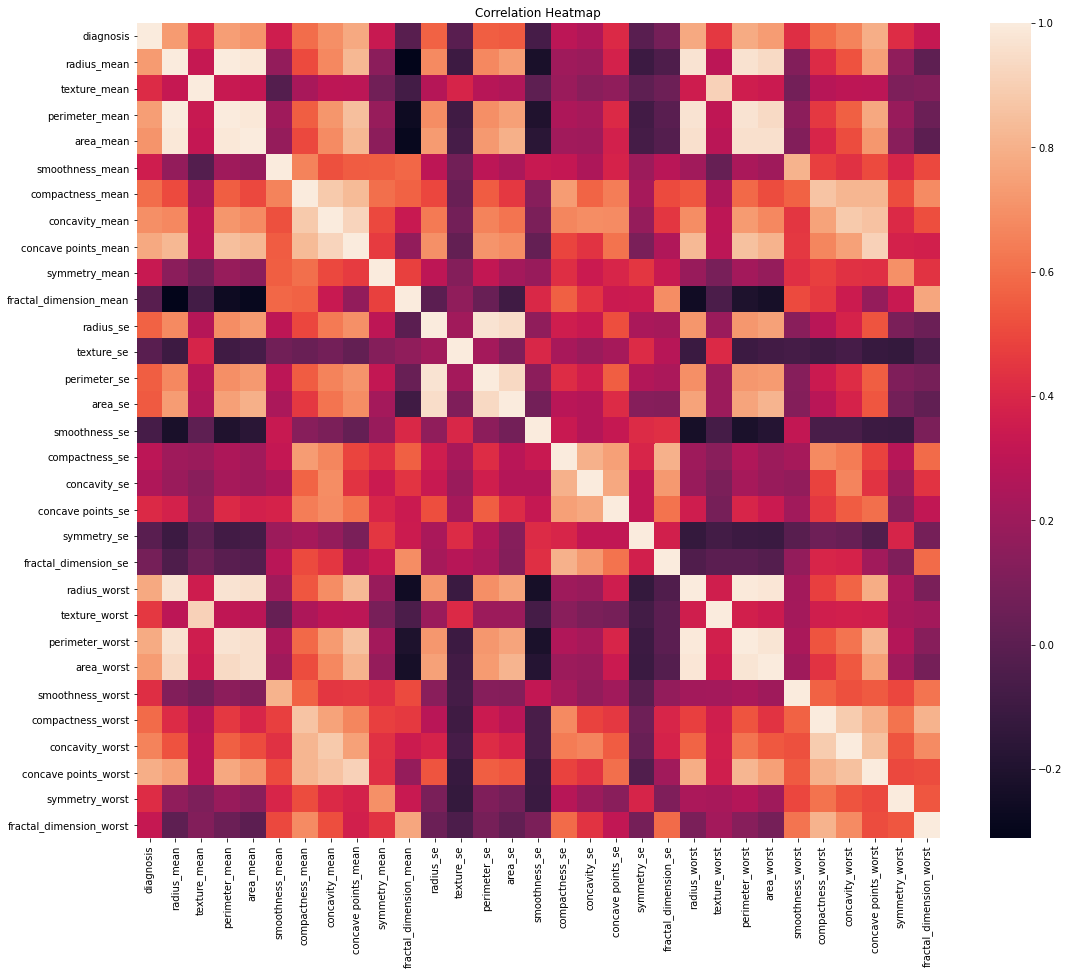


Mutual Information & Correlation of Each Feature with Target Feature
                         Mutual_Information  Correlation  Variance
perimeter_worst                        0.47         0.78      1.00
area_worst                             0.46         0.73      1.00
radius_worst                           0.46         0.78      1.00
concave points_worst                   0.43         0.79      1.00
concave points_mean                    0.43         0.78      1.00
perimeter_mean                         0.40         0.74      1.00
concavity_mean                         0.37         0.70      1.00
area_mean                              0.36         0.71      1.00
radius_mean                            0.36         0.73      1.00
area_se                                0.35         0.55      1.00
concavity_worst                        0.32         0.66      1.00
perimeter_se                           0.26         0.56      1.00
radius_se                              0.25         0.57   

In [12]:
# Feature Selection (Filter Methods Approach)
df_filter=master(df)
# Disclaimer: Categorical features were already label encoded in the above step.
# So the correlation heatmap includes all features to aid in filter based feature selection.

#### Comment:
We have selected the features that have the most mutual information and correlation with the Target Feature (Diagnosis). Mutual information is a measure of dependence between two variables - gauges how much a feature contributes to the prediction of the target variable. For mutual information we’ve determined that the mutual information less than 0.1 translates to weak connection of a feature with target feature. Correlation explains the extent to which two features are linearly related. We’ve determined correlation less than 0.3 translates to low correlation of a feature with target feature. Besides this rule we have omitted the following features from our set due to issues of multicollinearity:

Even though perimeter_ worst, area_ worst, radius_worst ,perimeter_mean, area_mean, and radius_mean all have significant correlation with diagnosis, we have only selected one feature out of these as they are highly correlated with each other and that one feature is perimeter_worst as it has the highest mutual information metric and correlation with diagnosis.

Similarly, out of concave points_worst, concave points_mean, concavity_mean and perimeter_se area_se, radius_se, we have selected concave points_worst and perimeter_se for the same reason as above.

Multicollinearity increases the model’s variance (resulting in a model where a small change in data or training leads to significant change in model’s learned parameters) and causes overfitting resulting in poor generalization. Moreover, it reduces interpretability as it hampers the ability to interpret individual effects of features on the target variable. Further, for models like OLS, it violates the assumption of linearity.

Note: Variance after standardization is kind of redundant as it has been normalized to 1.

In [13]:
# Feature Selection (Forward Feature Selection Approach)
df_wrapper_fwd=master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 1

How many features to select? 9

Following are the 9 features selected based on the given feature selector:

Index(['smoothness_mean', 'concavity_se', 'symmetry_se', 'radius_worst',
       'texture_worst', 'pe

#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset.

Here number of features are set equal to filter selection number above for better comparison of different methods.

In [14]:
# Feature Selection (Backward Feature Selection Approach)
df_wrapper_bck=master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 2

How many features to select? 9

Following are the 9 features selected based on the given feature selector:

Index(['radius_mean', 'smoothness_mean', 'concavity_mean', 'texture_se',
       'smoothness_se', 'sy

#### Comment:
For number of features same previous logic is applied.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 3


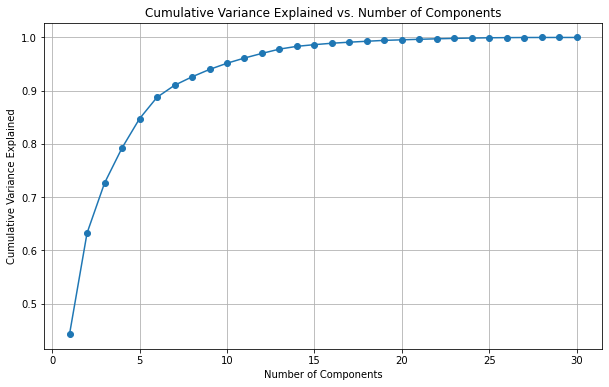


Enter the number of components for PCA: 9


In [15]:
# Dimensionality Reduction (PCA)
df_pca=master(df)

#### Comment:
Since first 9 components explain about 95% variability in the dataset, we've selected first 9 components as feature subset. Increasing the number of components increases cumulative variance but after 9 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor and pareto principal and can lead the model towards overfitting and therefore would be redundant as we're doing feature selection to avoid overfitting.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 9

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


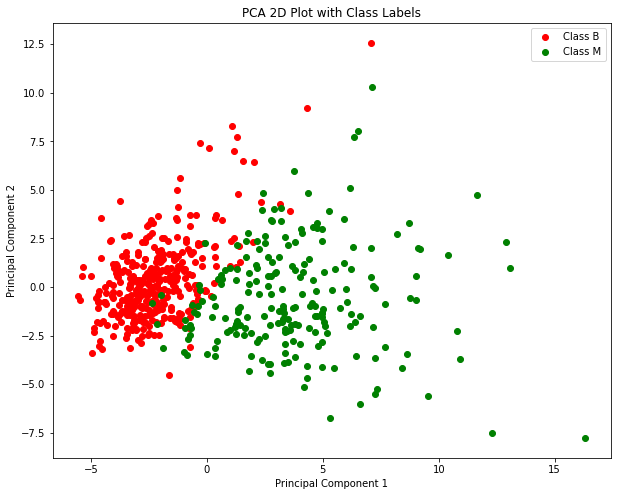

In [16]:
# Visualization by PCA
master(df)

#### Comment:
Using the first two principal components (which explain more than 50% variability of the data) we can visualize that there exists a distinct decision boundary between the two cancer diagnosis which means there exists a distinct mapping in the dataset (from features to diagnosis) which if learned efficiently can effectively predicted future diagnosis with good accuracy.

In [17]:
# Data Splitting
X_train,X_test,y_train,y_test=master(df) # baseline dataset
X_train_fil,X_test_fil,y_train_fil,y_test_fil=master(df_filter) # filter based feature selection dataset
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=master(df_wrapper_fwd) # wrapper (forward) based feature selection dataset
X_train_bck,X_test_bck,y_train_bck,y_test_bck=master(df_wrapper_bck) # wrapper (backward) based feature selection dataset
X_train_pca,X_test_pca,y_train_pca,y_test_pca=master(df_pca) # PCA based feature selection dataset

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 1

What % of data to be left for test? 20
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA 

In [18]:
# Model selection skipped as for this submission our model of choice is fixed (KNN)!

In [19]:
# Model Training
knn=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train)
knn_fil=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil)
knn_fwd=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd)
knn_bck=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck)
knn_pca=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca)
# Number of neighbours is pre-fixed as 5 (No hyperparameter tunning)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression

What is the problem type? 1
What is the value of K? 5
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualiza

In [20]:
# Fetching Results
result=master(knn=knn,X_test=X_test,y_test=y_test) # Returns a DataFrame
result_fil=master(knn=knn_fil,X_test=X_test_fil,y_test=y_test_fil) # Returns a DataFrame
result_fwd=master(knn=knn_fwd,X_test=X_test_fwd,y_test=y_test_fwd) # Returns a DataFrame
result_bck=master(knn=knn_bck,X_test=X_test_bck,y_test=y_test_bck) # Returns a DataFrame
result_pca=master(knn=knn_pca,X_test=X_test_pca,y_test=y_test_pca) # Returns a DataFrame

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression
What is the problem type? 1
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)


In [21]:
# Combined Result
d=[['Baseline', result.iloc[3][0],result.iloc[4][0]], ['Filter Subset', result_fil.iloc[3][0], result_fil.iloc[4][0]],
   ['FS Subset', result_fwd.iloc[3][0],result_fwd.iloc[4][0]], ['BS Subset', result_bck.iloc[3][0],result_bck.iloc[4][0]],
   ['PCA Subset', result_pca.iloc[3][0],result_pca.iloc[4][0]]]
result_comb1=pd.DataFrame(d,columns=['Subset','Testing Accuracy','AUC'])
result_comb1.sort_values(by=['Testing Accuracy','AUC'], ascending=False)

,Subset,Testing Accuracy,AUC
4,PCA Subset,0.98,0.99
0,Baseline,0.98,0.99
1,Filter Subset,0.97,0.98
2,FS Subset,0.96,0.99
3,BS Subset,0.96,0.97


In [22]:
# Detailed Result of the best subset
result_pca

,precision,recall,f1-score,support
M,0.97,1.00,0.99,73.00
B,1.00,0.95,0.97,41.00
---,---,---,---,---
accuracy,0.98,0.98,0.98,0.98
AUC,0.99,0.99,0.99,0.99


#### Result Interpretation:
PCA subset and baseline subset both show the highest accuracy and AUC score on test set, with PCA subset even improving metrics further. This suggests that by retaining the most informative aspects of the data while discarding redundant information, the model's predictive performance was enhanced. Even if opposite was the case, we would have still gone with PCA subset as baseline subset is unnecessary complex without much improvement in the predictive power which is against the Occam’s razor principal. If we penalize the model for overfitting (penalize feature increase so that it only makes sense to increase a feature it if significantly increases predictive power) then the baseline subset performance would drastically fall. All of this suggest that the baseline subset is not a good choice because of overfitting and unnecessary model complexity. In our case, PCA subset renders better AUC score and accuracy with only 9 components, addressing both concerns of overfitting and unnecessary model complexity.

---------------------------------------------------------------------------------------------------------------------------

##### Detailed Result (Using PCA Subset)
Classes: 'M' , 'B'

For the class 'M', the precision is 0.97, indicating that 97% of the diagnosis classified as 'M' are actually in the 'M' malignant cancer category.

For the class 'B', the precision is 1.00, indicating that 100% of the diagnosis classified as 'B' are actually in the 'B' benign cancer category.

For the class 'M', the recall is 1.00, indicating that 100% of the actual 'M' diagnosis were correctly identified by the classifier.

For the class 'B', the recall is 0.95, indicating that 95% of the actual 'B' diagnosis were correctly identified by the classifier.

For the class 'M', the F1-score is 0.99, representing the overall performance in terms of both precision and recall.

For the class 'B', the F1-score is 0.97, also representing the overall performance in terms of both precision and recall.

Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.98, or 98%.

AUC (Area Under the ROC Curve): The AUC score of 0.99 represents the model's ability to discriminate between malignant and benign diagnosis, with a higher value of 1 indicating perfect discrimination capability. Such high AUC score was expected as when we visualized data patterns using PCA, we saw that very distinct decision boundaries can be learned and that the diagnosis are segregated and data has inherent pattern which can allow learning from features to diagnosis.

Since KNN doesn’t have a training phase where model weights are learned, it’s hard to comment whether this value of accuracy or AUC indicates an overfit. However, using CV we can compare the model fitness across different subsets of the data to get a more realistic idea and then compare it with our train-test subset to comment whether the model performance on this train-test subset is suggesting overfitting. 

### Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)

In [23]:
# Now moving onto our CV vs. Non-CV analysis we'll fix our feature selection (PCA Subset)
folds=master(df_pca)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 2

How many folds required? 5


In [24]:
scoresCV=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca,sk_folds=folds)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

What is the value of K? 5


In [25]:
scoresCV=master(scoresCV=scoresCV)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

Cross-Validation Evaluation
Average CV Accuracy Score:  0.968390001552554
Average CV ROC-AUC Score:  0.9886668525364071
Number of CV Scores used in Average:  5


In [26]:
da=[["Train-Test Split",result_pca.iloc[3][0],result_pca.iloc[4][0]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[2],np.mean(scoresCV)[3]]]
resultCvsNC1=pd.DataFrame(da, columns=['Approach','Testing Accuracy Score', 'ROC-AUC Score'])
resultCvsNC1.sort_values(by=['Testing Accuracy Score','ROC-AUC Score'],ascending=False)

,Approach,Testing Accuracy Score,ROC-AUC Score
0,Train-Test Split,0.98,0.99
1,Cross-Validation (Avg),0.97,0.99


#### Interpretation:
Cross-validation is used to estimate a model's generalization performance and avoid overfitting by evaluating the model on multiple subsets of the data (As it can also help us find out and train model on the subset that renders accuracy closest to the average cross validation accuracy to be more generalizable).

The slightly higher accuracy obtained from the single train-test or train-validation split compared to the average accuracy across 5 different data subsets suggests that the model performs slightly better on that particular split of the data. However, the discrepancy is too small to take notice of and we can comment that the model wasn't overfitting on the initial train-test data subset as on average it's accuracy and ROC scores are similar to those obtained by our model on the initial train-test subset. So the model generalizes well to unseen data and also performs well, as indicated by high accuracies and AUC scores between train-test subset and cross validation averages, and low variability in the score between train-test subset and cross validation averages.

# Congressional Voting Records
source : https://archive.ics.uci.edu/dataset/105/congressional+voting+records

### Data Preprocessing & EDA

In [29]:
df,label_column=master()
df.head()

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 1

Please enter the UCI ID 105
Successfuly Connected to the Data Source


,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Class
0,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN,republican
2,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y,democrat


In [30]:
# Data Cleaning
master(df)
# This function first checks for duplicate values and drop them
# Then it imputes categorical missing values with modal value
# Afterwards it uses KNN imputer to impute missing values for numerical variables
# Overall it checks what type of cleaning is required (if any) and acts accordingly!

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 2
Dataset is treated for duplicated values successfully
Dataset is treated for missing values successfully


In [31]:
# Since there are no numerical features, numerical EDA and summary won't be possible
# Only Class Balance Statistic can be analyzed
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 4


democrat     65.79
republican   34.21
Name: Class, dtype: float64

In [32]:
# Outlier Analysis & Treatment functionality is still under progress!
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 6


'Outlier detection and treatment functionality under progress!'

In [33]:
# Data Transformation
master(df)
# This function first label encode categorical features so that they become numerical (except the target variable)
# Then it uses standard or min-max scaler to standardize all numerical feature (so doesn't apply on target variable)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


### Feature Selection

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 1




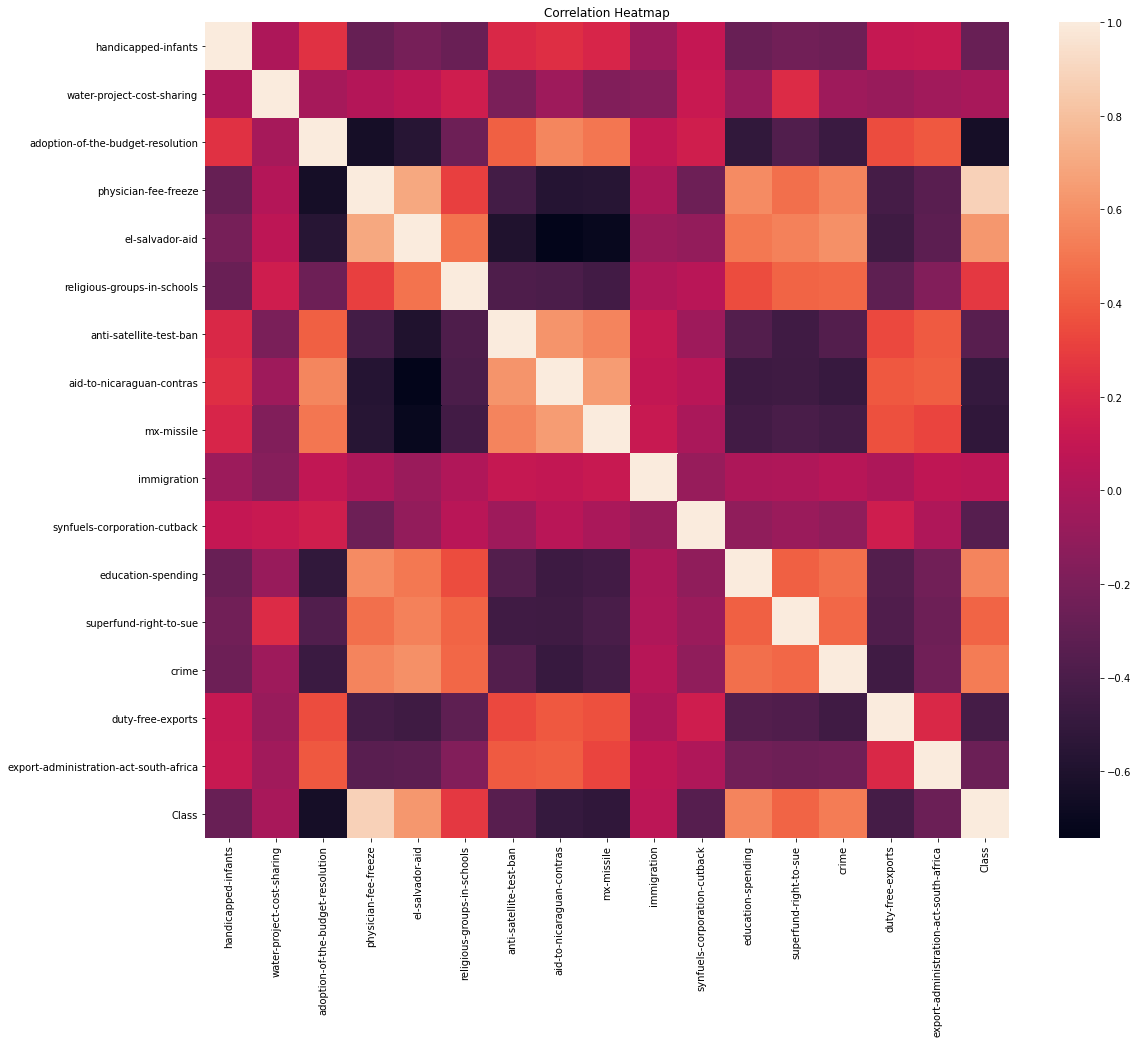


Mutual Information & Correlation of Each Feature with Target Feature
                                        Mutual_Information  Correlation  \
physician-fee-freeze                                  0.43         0.88   
el-salvador-aid                                       0.22         0.63   
adoption-of-the-budget-resolution                     0.18         0.65   
crime                                                 0.16         0.52   
mx-missile                                            0.15         0.52   
education-spending                                    0.13         0.55   
aid-to-nicaraguan-contras                             0.12         0.49   
duty-free-exports                                     0.09         0.42   
superfund-right-to-sue                                0.09         0.43   
synfuels-corporation-cutback                          0.07         0.35   
anti-satellite-test-ban                               0.07         0.34   
export-administration-act-sout

In [34]:
# Feature Selection (Filter Methods Approach)
df_filter=master(df)

#### Comment:
We have selected top 7 features based on mutual information and correlation as after 7 features mutual information metric suggests a very weak connection with target variable (between 0 to 0.10) and the correlation metric also generally indicates low correlation with target variable for the rest of the features (less than 0.49).
Also note that after checking corelation between features there were corelations in between but not as high range between (1 - 0.8)
Note: Variance after standardization is kind of redundant as it has been normalized to 1.

In [35]:
# Feature Selection (Forward Feature Selection Approach)
df_wrapper_fwd=master(df)
# Number of feature parameter is used as a stopping criteria
# Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline
# There's no universal tolerance criteria as it varies for each dataset
# Here number of features are set equal to filter selection number above for better comparison of different methods

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 1

How many features to select? 7

Following are the 7 features selected based on the given feature selector:

Index(['handicapped-infants', 'water-project-cost-sharing',
       'physician-fee-freeze', 'el-salva

#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset.

Here number of features are set equal to filter selection number above for better comparison of different methods

In [36]:
# Feature Selection (Backward Feature Selection Approach)
df_wrapper_bck=master(df)
# For number of features same previous logic is applied

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 2

How many features to select? 7

Following are the 7 features selected based on the given feature selector:

Index(['adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'anti-

#### Comment:
For number of features same previous logic is applied.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 3


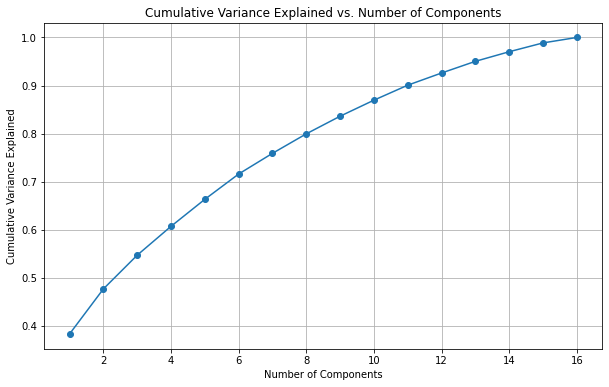


Enter the number of components for PCA: 12


In [37]:
# Dimensionality Reduction (PCA)
df_pca=master(df)

#### Comment:
Since first 12 components explain about 92.5% variability in the dataset, we've selected first 12 components as feature subset. Increasing the number of components increases cumulative variance but after 12 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor and pareto principal and can lead the model towards overfitting and therefore would be redundant as we're doing feature selection to avoid overfitting.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 9

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


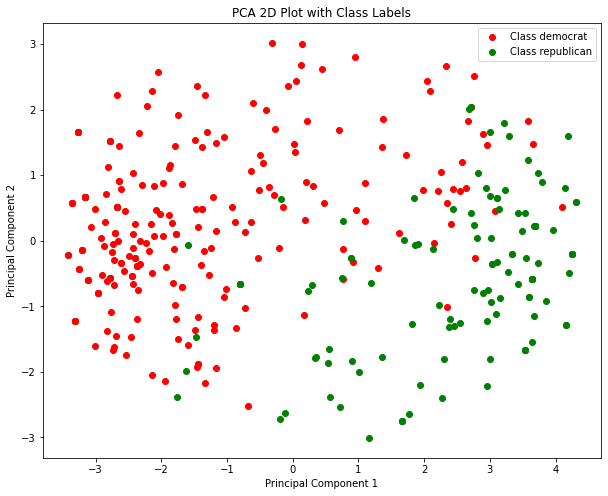

In [38]:
# Visualization by PCA
master(df)

#### Comment:
Using the first two principal components (which explain about 48% of the data) we can visualize that there seems to be some separation between the red and green clusters, suggesting potential differences between Democrats and Republicans, however there's some overlap as well, also note that democrate are close cluster i.e they are slighlty more packed than republican which is more spread, hence it shows democrates having more consistency whereas republicans show some more variation

In [39]:
# Data Splitting
X_train,X_test,y_train,y_test=master(df) # baseline dataset
X_train_fil,X_test_fil,y_train_fil,y_test_fil=master(df_filter) # filter based feature selection dataset
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=master(df_wrapper_fwd) # wrapper (forward) based feature selection dataset
X_train_bck,X_test_bck,y_train_bck,y_test_bck=master(df_wrapper_bck) # wrapper (backward) based feature selection dataset
X_train_pca,X_test_pca,y_train_pca,y_test_pca=master(df_pca) # PCA based feature selection dataset

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 1

What % of data to be left for test? 20
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA 

In [40]:
# model selection is not required as KNN is only required

In [41]:
# Model Training
knn=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train)
knn_fil=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil)
knn_fwd=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd)
knn_bck=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck)
knn_pca=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca)
# Number of neighbours is pre-fixed as 5 (No hyperparameter tunning)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression

What is the problem type? 1
What is the value of K? 5
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualiza

In [42]:
# Fetching Results
result=master(knn=knn,X_test=X_test,y_test=y_test) # Returns a DataFrame
result_fil=master(knn=knn_fil,X_test=X_test_fil,y_test=y_test_fil) # Returns a DataFrame
result_fwd=master(knn=knn_fwd,X_test=X_test_fwd,y_test=y_test_fwd) # Returns a DataFrame
result_bck=master(knn=knn_bck,X_test=X_test_bck,y_test=y_test_bck) # Returns a DataFrame
result_pca=master(knn=knn_pca,X_test=X_test_pca,y_test=y_test_pca) # Returns a DataFrame

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression
What is the problem type? 1
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)


In [43]:
# Combined Result
d=[['Baseline', result.iloc[3][0],result.iloc[4][0]], ['Filter Subset', result_fil.iloc[3][0], result_fil.iloc[4][0]],
   ['FS Subset', result_fwd.iloc[3][0],result_fwd.iloc[4][0]], ['BS Subset', result_bck.iloc[3][0],result_bck.iloc[4][0]],
   ['PCA Subset', result_pca.iloc[3][0],result_pca.iloc[4][0]]]
result_comb3=pd.DataFrame(d,columns=['Subset','Testing Accuracy','AUC'])
result_comb3.sort_values(by=['Testing Accuracy','AUC'], ascending=False)

,Subset,Testing Accuracy,AUC
3,BS Subset,0.90,0.90
2,FS Subset,0.88,0.89
4,PCA Subset,0.87,0.91
0,Baseline,0.87,0.87
1,Filter Subset,0.86,0.91


In [44]:
# Detailed Result of the best subset
result_bck

,precision,recall,f1-score,support
republican,0.91,0.93,0.92,42.00
democrat,0.88,0.85,0.87,27.00
---,---,---,---,---
accuracy,0.90,0.90,0.90,0.90
AUC,0.90,0.90,0.90,0.90


#### Result Interpretation:
Here Backward Selection shows having highest testing accuracy and PCA subset having highest AUC indicating that Baseline subset that has all the features included has gotten overfit over it's test model whereas backward selection gradually weaned off features and here instead of model selecting on it's own we provide it with 7 features which gives the best result out of all but it may not perform as well on live test, Another thing is with PCA we provide 12 components shows that highest AUC or highest correct prediction rate

---------------------------------------------------------------------------------------------------------------------------

##### Detailed Result (Using Backward Feature Selection Subset)
Classes: 'Republican' , 'Democrat'

For the class 'Republican', the precision is 0.91, indicating that 91% of the Predicted class as 'Republican' are actually in the 'Republican' Congress Voting category.

For the class 'Democrat', the precision is 0.88, indicating that 88% of the Predicted class as 'Democrat' are actually in the 'Democrat' Congress Voting category.

For the class 'Republican', the recall is 0.93, indicating that 93% of the actual 'Republican' Predicted were correctly identified by the classifier.

For the class 'Democrat', the recall is 0.85, indicating that 85% of the actual 'Democrat' Predicted were correctly identified by the classifier.

For the class 'Republican', the F1-score is 0.92, representing the overall performance in terms of both precision and recall.

For the class 'Democrat', the F1-score is 0.87, also representing the overall performance in terms of both precision and recall.

Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.90, or 90%.

AUC (Area Under the ROC Curve): The AUC score of 0.90 represents the model's ability to discriminate between Republican and Democrat, with a higher value of 1 indicating perfect discrimination capability. Such AUC score was expected as when we visualized data patterns using PCA, we saw that very clear sepreation between both clusters with slight overlap showing both parties thinking difference showing in the form of votes, which can allow learning from features to identification.

Since KNN doesn’t have a training phase where model weights are learned, it’s hard to comment whether this value of accuracy or AUC indicates an overfit. However, using CV we can compare the model fitness across different subsets of the data to get a more realistic idea and then compare it with our train-test subset to comment whether the model performance on this train-test subset is suggesting overfitting.

### Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)

In [45]:
# Now moving onto our CV vs. Non-CV analysis we'll fix our feature selection (Backward Feature Selection Subset)
folds=master(df_wrapper_bck)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 2

How many folds required? 5


In [46]:
scoresCV=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck,sk_folds=folds)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

What is the value of K? 5


In [47]:
scoresCV=master(scoresCV=scoresCV)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

Cross-Validation Evaluation
Average CV Accuracy Score:  0.9560528559249788
Average CV ROC-AUC Score:  0.9776247987117552
Number of CV Scores used in Average:  5


In [48]:
da=[["Train-Test Split",result_bck.iloc[3][0],result_bck.iloc[4][0]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[2],np.mean(scoresCV)[3]]]
resultCvsNC3=pd.DataFrame(da, columns=['Approach','Testing Accuracy Score', 'ROC-AUC Score'])
resultCvsNC3.sort_values(by=['Testing Accuracy Score','ROC-AUC Score'],ascending=False)

,Approach,Testing Accuracy Score,ROC-AUC Score
1,Cross-Validation (Avg),0.96,0.98
0,Train-Test Split,0.90,0.90


#### Interpretation:
Cross-validation is used to estimate a model's generalization performance and avoid overfitting by evaluating the model on multiple subsets of the data (As it can also help us find out and train model on the subset that renders accuracy closest to the average cross validation accuracy to be more generalizable).


Cross-validation involves splitting the dataset into multiple subsets (folds), training the model on different combinations of these subsets, and then averaging the performance across these folds.

Here the higher Cross-validation indicates that the model generalizes well across different subsets of the data. This suggests that the model's performance is more reliable and less dependent on the particular data points in the test set. This also suggests that the model slightly underfitted on the intial train-test split than its actual potential.

AUC follows the same reasoning but for model's ability to discriminate between classes or predict probabilities is more consistent across different subsets of the data hence the above reasoning

# Predict Students' Dropout and Academic Success
Source: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [49]:
df,label_column=master()
df.head()

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 1

Please enter the UCI ID 697
Successfuly Connected to the Data Source


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.00,1,19,12,...,0,0,0,0,0.00,0,10.80,1.40,1.74,Dropout
1,1,15,1,9254,1,1,160.00,1,1,3,...,0,6,6,6,13.67,0,13.90,-0.30,0.79,Graduate
2,1,1,5,9070,1,1,122.00,1,37,37,...,0,6,0,0,0.00,0,10.80,1.40,1.74,Dropout
3,1,17,2,9773,1,1,122.00,1,38,37,...,0,6,10,5,12.40,0,9.40,-0.80,-3.12,Graduate
4,2,39,1,8014,0,1,100.00,1,37,38,...,0,6,6,6,13.00,0,13.90,-0.30,0.79,Graduate


### Data Preprocessing & EDA

In [50]:
# Data Cleaning
master(df)
# This function first checks for duplicate values and drop them
# Then it imputes categorical missing values with modal value
# Afterwards it uses KNN imputer to impute missing values for numerical variables
# Overall it checks what type of cleaning is required (if any) and acts accordingly!

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 2


'Dataset is Already Clean!'

In [51]:
# Summary of Numerical Variables
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 3


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,...,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00
mean,1.18,18.67,1.73,8856.64,0.89,4.58,132.61,1.87,19.56,22.28,...,0.14,0.54,6.23,8.06,4.44,10.23,0.15,11.57,1.23,0.00
std,0.61,17.48,1.31,2063.57,0.31,10.22,13.19,6.91,15.60,15.34,...,0.69,1.92,2.20,3.95,3.01,5.21,0.75,2.66,1.38,2.27
min,1.00,1.00,0.00,33.00,0.00,1.00,95.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.60,-0.80,-4.06
25%,1.00,1.00,1.00,9085.00,1.00,1.00,125.00,1.00,2.00,3.00,...,0.00,0.00,5.00,6.00,2.00,10.75,0.00,9.40,0.30,-1.70
50%,1.00,17.00,1.00,9238.00,1.00,1.00,133.10,1.00,19.00,19.00,...,0.00,0.00,6.00,8.00,5.00,12.20,0.00,11.10,1.40,0.32
75%,1.00,39.00,2.00,9556.00,1.00,1.00,140.00,1.00,37.00,37.00,...,0.00,0.00,7.00,10.00,6.00,13.33,0.00,13.90,2.60,1.79
max,6.00,57.00,9.00,9991.00,1.00,43.00,190.00,109.00,44.00,44.00,...,12.00,19.00,23.00,33.00,20.00,18.57,12.00,16.20,3.70,3.51


In [52]:
# Class Balance
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 4


Graduate   49.93
Dropout    32.12
Enrolled   17.95
Name: Target, dtype: float64

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 5

Histogram and Box Plot - Curricular units 2nd sem (approved)


<Figure size 720x432 with 0 Axes>

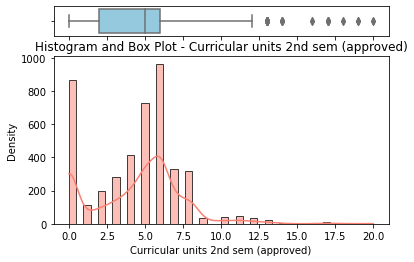

Skewness: 0.30617552674333876
Right Skewed 

Kurtosis: 0.8427339603622421
Platykurtic 

JB Test for Normality
200.03380346056755 0.0
Distribution is not normal 


Histogram and Box Plot - Curricular units 2nd sem (grade)


<Figure size 720x432 with 0 Axes>

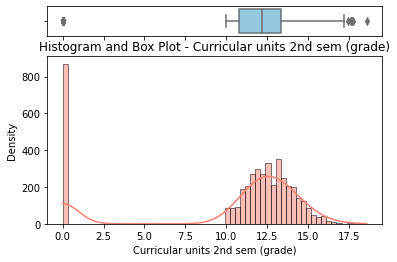

Skewness: -1.3132047205247324
Left Skewed 

Kurtosis: 0.06513620855378965
Platykurtic 

JB Test for Normality
1272.3183035224288 0.0
Distribution is not normal 


Histogram and Box Plot - Curricular units 1st sem (approved)


<Figure size 720x432 with 0 Axes>

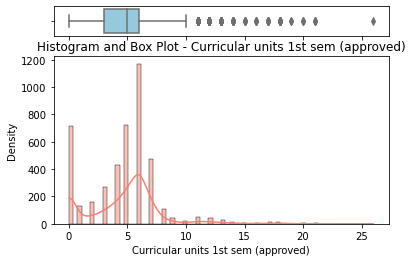

Skewness: 0.7660025646036546
Right Skewed 

Kurtosis: 3.091825190583015
Leptokurtic 

JB Test for Normality
2194.750588982593 0.0
Distribution is not normal 


Histogram and Box Plot - Curricular units 1st sem (grade)


<Figure size 720x432 with 0 Axes>

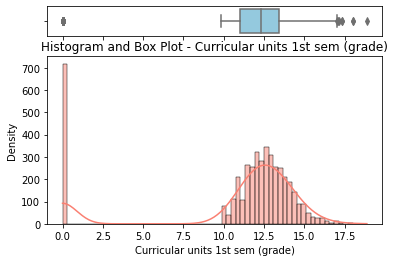

Skewness: -1.5676138494008287
Left Skewed 

Kurtosis: 0.906078681229515
Platykurtic 

JB Test for Normality
1963.266369617066 0.0
Distribution is not normal 


Histogram and Box Plot - Admission grade


<Figure size 720x432 with 0 Axes>

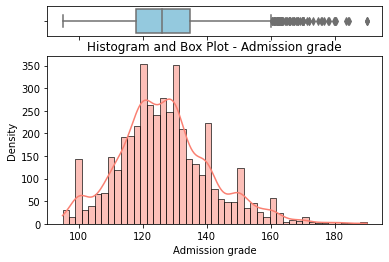

Skewness: 0.5304199391062183
Right Skewed 

Kurtosis: 0.6606198935925089
Platykurtic 

JB Test for Normality
287.89177991060797 0.0
Distribution is not normal 



In [53]:
# Histogram & Box Plot of top 5 most significant numerical features
master(df)

#### EDA Interpretation:

##### Class Imbalance:
There exists a class imbalance where the Graduate class almost doubles the combine class of enrolled and dropout. In this case, the dataset is skewed towards the Graduate class. This could lead to models that are better at predicting the majority class but perform poorly on the minority class (dropout & enrolled) which is in reality the significant class. So during evaluation instead of just looking at overall accuracy, precision, recall & f1-scoreC should be given preferance.

---------------------------------------------------------------------------------------------------------------------------
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance. These features are perimeter_worst, concave points_worst, radius_worst, concave points_mean, and area_worst.

##### Curricular units 2nd sem (approved): 
It basically indicates the number of cutticular unit approved in second semester
1. Data has a slight right skew.
2. It exhibits a platykurtic distribution, meaning it has lighter tails than a normal distribution.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### Curricular units 2nd sem (grade):
It shows the grade obtain in 2nd semester
1. Data is left-skewed with a skewness of -1.313.
2. It exhibits a platykurtic distribution with a kurtosis of 0.065.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### Curricular units 1st sem (approved):
It basically indicates the number of cutticular unit approved in 1st semester
1. data is right-skewed with a skewness of 0.766.
2. It exhibits a leptokurtic distribution with a kurtosis of 3.092.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### Curricular units 1st sem (grade):
It shows the grade obtain in 2nd semester
1. data is left-skewed with a skewness of -1.568.
2. It exhibits a platykurtic distribution with a kurtosis of 0.906.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### Admission grade:
The grades obtain in admission
1. data is right-skewed with a skewness of 0.530.
2. It exhibits a platykurtic distribution with a kurtosis of 0.661.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

In [54]:
# Outlier Analysis & Treatment functionality is still under progress!
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 6


'Outlier detection and treatment functionality under progress!'

In [55]:
# Data Transformation
master(df)
# This function first label encode categorical features so that they become numerical (except the target variable)
# Then it uses standard or min-max scaler to standardize all numerical feature (so doesn't apply on target variable)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


### Feature Selection

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 1




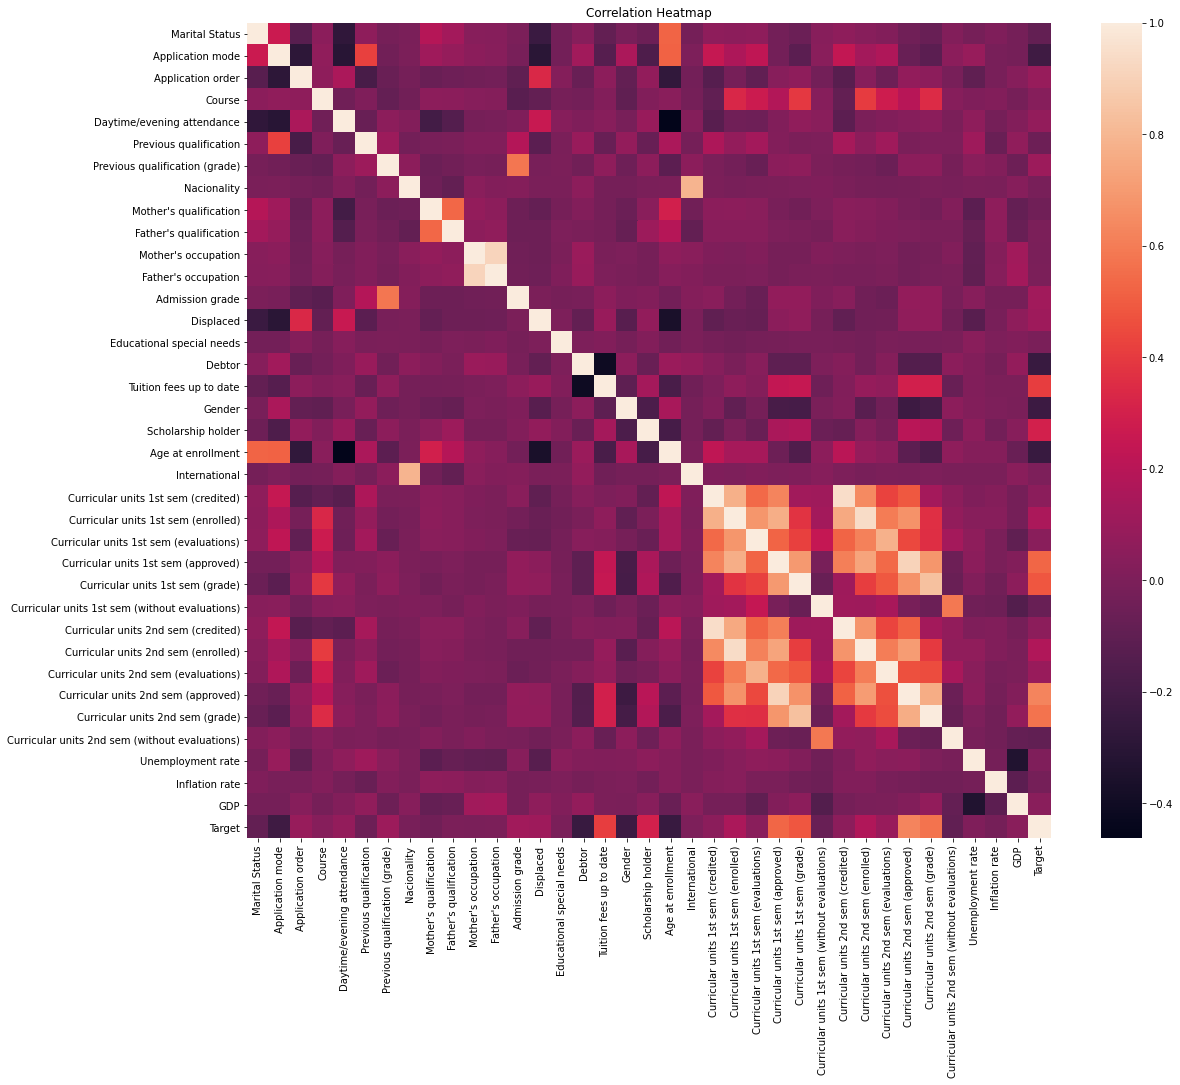


Mutual Information & Correlation of Each Feature with Target Feature
                                                Mutual_Information  \
Curricular units 2nd sem (approved)                           0.32   
Curricular units 1st sem (approved)                           0.25   
Curricular units 2nd sem (grade)                              0.22   
Curricular units 1st sem (grade)                              0.17   
Curricular units 2nd sem (evaluations)                        0.09   
Curricular units 1st sem (evaluations)                        0.09   
Tuition fees up to date                                       0.09   
Age at enrollment                                             0.06   
Curricular units 2nd sem (enrolled)                           0.06   
Scholarship holder                                            0.05   
Course                                                        0.05   
Curricular units 1st sem (enrolled)                           0.05   
Application mode    

In [56]:
# Feature Selection (Filter Methods Approach)
df_filter=master(df)

#### Comment:
Above selected features were based on the correlation range (1 - 0.2) as shown above not many are highly correlated so in order to avoid underfitting the model the range was extended upto 0.2 hence these 10  features were selected.

In [57]:
# Feature Selection (Forward Feature Selection Approach)
df_wrapper_fwd=master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 1

How many features to select? 10

Following are the 10 features selected based on the given feature selector:

Index(['Course', 'Nacionality', 'Educational special needs',
       'Tuition fees up to date', 'In

#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset.

Here number of features are set equal to filter selection number above for better comparison of different methods

In [58]:
# Feature Selection (Backward Feature Selection Approach)
df_wrapper_bck=master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 2

How many features to select? 10

Following are the 10 features selected based on the given feature selector:

Index(['Course', 'Father's occupation', 'Tuition fees up to date', 'Gender',
       'Scholarship h

#### Comment:
For number of features same previous logic is applied.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 3


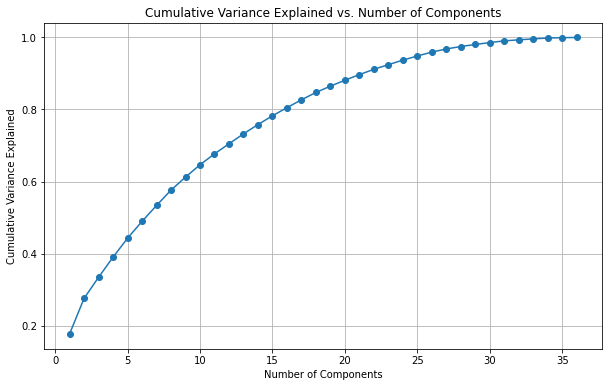


Enter the number of components for PCA: 20


In [59]:
# Dimensionality Reduction (PCA)
df_pca=master(df)

#### Comment:
First 20 components explain upto 90% of the variability in the data.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 9

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


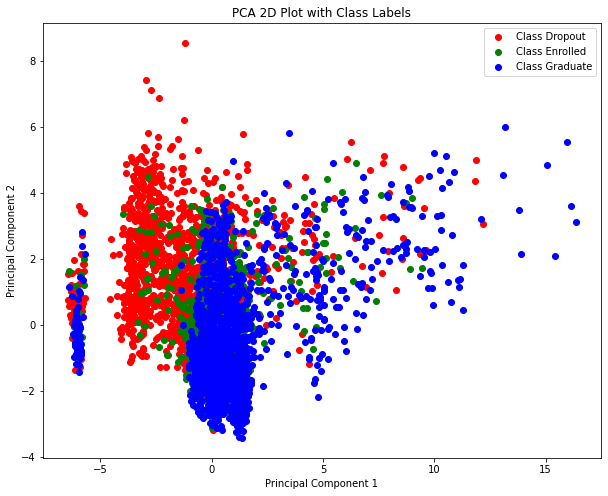

In [60]:
# Visualization by PCA
master(df)

#### Comment:
No distinct values could be found but a close cluster of graduates show very low variance indicating much similar patern
same dropout there cluster are closer and even over lap with enrolled and some entities slightly overlap with gradutes as well

whereas enrolled are overlapped with both graduates and dropout indicating possiblities that amoung enrolled some might gradute and some might dropout

In [61]:
# Data Splitting
X_train,X_test,y_train,y_test=master(df) # baseline dataset
X_train_fil,X_test_fil,y_train_fil,y_test_fil=master(df_filter) # filter based feature selection dataset
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=master(df_wrapper_fwd) # wrapper (forward) based feature selection dataset
X_train_bck,X_test_bck,y_train_bck,y_test_bck=master(df_wrapper_bck) # wrapper (backward) based feature selection dataset
X_train_pca,X_test_pca,y_train_pca,y_test_pca=master(df_pca) # PCA based feature selection dataset

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 1

What % of data to be left for test? 20
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA 

In [62]:
# Model selection skipped as for this submission our model of choice is fixed (KNN)!

In [63]:
# Model Training
knn=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train)
knn_fil=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil)
knn_fwd=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd)
knn_bck=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck)
knn_pca=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca)
# Number of neighbours is pre-fixed as 5 (No hyperparameter tunning)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression

What is the problem type? 1
What is the value of K? 5
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualiza

In [64]:
# Fetching Results
result=master(knn=knn,X_test=X_test,y_test=y_test) # Returns a DataFrame
result_fil=master(knn=knn_fil,X_test=X_test_fil,y_test=y_test_fil) # Returns a DataFrame
result_fwd=master(knn=knn_fwd,X_test=X_test_fwd,y_test=y_test_fwd) # Returns a DataFrame
result_bck=master(knn=knn_bck,X_test=X_test_bck,y_test=y_test_bck) # Returns a DataFrame
result_pca=master(knn=knn_pca,X_test=X_test_pca,y_test=y_test_pca) # Returns a DataFrame

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression
What is the problem type? 1
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)


In [65]:
# Combined Result
d=[['Baseline', result.iloc[3][0]], ['Filter Subset', result_fil.iloc[3][0]],
   ['FS Subset', result_fwd.iloc[3][0]], ['BS Subset', result_bck.iloc[3][0]],
   ['PCA Subset', result_pca.iloc[3][0]]]
result_comb4=pd.DataFrame(d,columns=['Subset','Testing Accuracy'])
result_comb4.sort_values(by=['Testing Accuracy'], ascending=False)

,Subset,Testing Accuracy
3,BS Subset,0.76
2,FS Subset,0.75
4,PCA Subset,0.71
0,Baseline,0.71
1,Filter Subset,0.71


In [66]:
# Detailed Result of the best subset
result_bck

,precision,recall,f1-score,support
Dropout,0.76,0.80,0.78,277.00
Graduate,0.52,0.35,0.42,158.00
Enrolled,0.81,0.88,0.85,450.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.70,0.68,0.68,885.00
weighted avg,0.75,0.76,0.75,885.00


#### Result Interpretation:
Here Backward Selection shows having highest testing accuracy Baseline subset that has all the features included has gotten overfit over it's test model whereas backward selection gradually weaned off features and here instead of model selecting on it's own we provide it with 10 features which gives the best result out of all but it may not perform as well on live test, 

---------------------------------------------------------------------------------------------------------------------------

##### Detailed Result (Using Backward-Selection Subset)
Classes: 'Dropout' , 'Graduate','Enrolled'

For the class 'Dropout', the precision is 0.76, indicating that 76% of the Predicted class as 'Dropout' are actually in the 'Dropout' Students category.

For the class 'Graduate', the precision is 0.52, indicating that 52% of the Predicted class as 'Graduate' are actually in the 'Graduate' Student category.

For the class 'Enrolled', the precision is 0.81, indicating that 81% of the Predicted class as 'Dropout' are actually in the 'Enrolled' Students category.

For the class 'Dropout', the recall is 0.80, indicating that 80% of the actual 'Dropout' Predicted were correctly identified by the classifier.

For the class 'Graduate', the recall is 0.35, indicating that 35% of the actual 'Graduate' Predicted were correctly identified by the classifier.

For the class 'Enrolled', the recall is 0.88, indicating that 88% of the actual 'Enrolled' Predicted were correctly identified by the classifier.

For the class 'Dropout', the F1-score is 0.78, representing the overall performance in terms of both precision and recall.

For the class 'Graduate', the F1-score is 0.42, also representing the overall performance in terms of both precision and recall.

For the class 'Enrolled', the F1-score is 0.85, representing the overall performance in terms of both precision and recall

Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.76, or 76%.

Here it can be observed that results for accuracy, recall and F1 score for Graduate is not good but this can be expected as above in PCA plot we can see Graduate class overlaps with both enrolled and dropout and their pointers are all over the graph showing many outliers  in it.

Since KNN doesn’t have a training phase where model weights are learned, it’s hard to comment whether this value of accuracy indicates an overfit. However, using CV we can compare the model fitness across different subsets of the data to get a more realistic idea and then compare it with our train-test subset to comment whether the model performance on this train-test subset is suggesting overfitting.

### Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)

In [67]:
# Now moving onto our CV vs. Non-CV analysis we'll fix our feature selection (BFS Subset)
folds=master(df_wrapper_bck)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 2

How many folds required? 5


In [68]:
scoresCV=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck,sk_folds=folds)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

What is the value of K? 5


In [69]:
scoresCV=master(scoresCV=scoresCV)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 1

Cross-Validation Evaluation
Average CV Accuracy Score:  0.7427744970217552
Number of CV Scores used in Average:  5


In [70]:
da=[["Train-Test Split",result_bck.iloc[3][0]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[2]]]
resultCvsNC4=pd.DataFrame(da, columns=['Approach','Testing Accuracy Score'])
resultCvsNC4.sort_values(by=['Testing Accuracy Score'],ascending=False)

,Approach,Testing Accuracy Score
0,Train-Test Split,0.76
1,Cross-Validation (Avg),0.74


#### Interpretation:
Cross-validation is used to estimate a model's generalization performance and avoid overfitting by evaluating the model on multiple subsets of the data (As it can also help us find out and train model on the subset that renders accuracy closest to the average cross validation accuracy to be more generalizable).

Cross-validation involves splitting the dataset into multiple subsets (folds), training the model on different combinations of these subsets, and then averaging the performance across these folds.

The slightly higher accuracy obtained from the single train-test or train-validation split compared to the average accuracy across 5 different data subsets suggests that the model performs slightly better on that particular split of the data. However, the discrepancy is too small to take notice of and we can comment that the model wasn't overfitting on the initial train-test data subset as on average it's accuracy scores are similar to those obtained by our model on the initial train-test subset. So the model generalizes well to unseen data and also performs well.

# Regression Datasets

# Life Expectancy (WHO)

### Data Preprocessing & EDA

In [71]:
# Dataset loading (can use pipeline function if dataset is fetched from UCI using uci dataset id)
df=pd.read_csv("Regression.Life.Expectancy.csv")
label_column='Life expectancy ' #label here means target variable
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,...,6.00,8.16,65.00,0.10,584.26,33736494.00,17.20,17.30,0.48,10.10
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,...,58.00,8.18,62.00,0.10,612.70,327582.00,17.50,17.50,0.48,10.00
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,...,62.00,8.13,64.00,0.10,631.74,31731688.00,17.70,17.70,0.47,9.90
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,...,67.00,8.52,67.00,0.10,669.96,3696958.00,17.90,18.00,0.46,9.80
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,...,68.00,7.87,68.00,0.10,63.54,2978599.00,18.20,18.20,0.45,9.50


In [72]:
# Data Cleaning
master(df)
# This function first checks for duplicate values and drop them
# Then it imputes categorical missing values with modal value
# Afterwards it uses KNN imputer to impute missing values for numerical variables
# Overall it checks what type of cleaning is required (if any) and acts accordingly!

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 2
Dataset is treated for missing values successfully


In [73]:
# Summary of Numerical Variables
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 3


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00,2938.00
mean,2007.52,69.24,164.67,30.30,4.59,738.25,81.05,2419.59,38.19,42.04,82.48,5.95,82.25,1.74,6667.91,12259272.24,4.86,4.89,0.62,11.94
std,4.61,9.52,124.14,117.93,4.00,1987.91,23.54,11467.27,19.98,160.45,23.42,2.43,23.71,5.08,13348.22,55512452.21,4.41,4.50,0.21,3.34
min,2000.00,36.30,1.00,0.00,0.01,0.00,1.00,0.00,1.00,0.00,3.00,0.37,2.00,0.10,1.68,34.00,0.10,0.10,0.00,0.00
25%,2004.00,63.20,74.00,0.00,1.02,4.69,75.60,0.00,19.40,0.00,78.00,4.34,78.00,0.10,458.87,376903.75,1.60,1.60,0.49,10.00
50%,2008.00,72.10,144.00,3.00,3.69,64.91,91.00,17.00,43.00,4.00,93.00,5.80,93.00,0.10,1569.02,2031486.80,3.40,3.40,0.67,12.30
75%,2012.00,75.70,227.00,22.00,7.60,441.53,96.00,360.25,56.10,28.00,97.00,7.41,97.00,0.80,5306.75,8169033.00,7.20,7.20,0.78,14.20
max,2015.00,89.00,723.00,1800.00,17.87,19479.91,99.00,212183.00,87.30,2500.00,99.00,17.60,99.00,50.60,119172.74,1293859294.00,27.70,28.60,0.95,20.70


1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 5

Histogram and Box Plot -  HIV/AIDS


<Figure size 720x432 with 0 Axes>

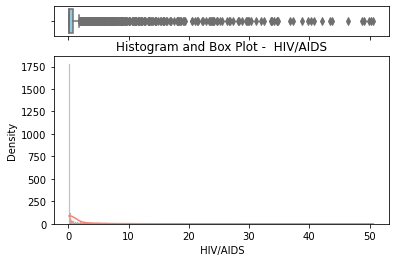

Skewness: 5.393356658787256
Right Skewed 

Kurtosis: 34.83061410656787
Leptokurtic 

JB Test for Normality
162756.00200782967 0.0
Distribution is not normal 


Histogram and Box Plot - Income composition of resources


<Figure size 720x432 with 0 Axes>

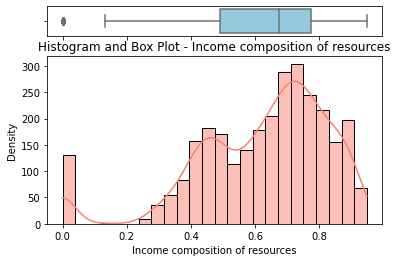

Skewness: -1.0956769733395706
Left Skewed 

Kurtosis: 1.3067476915307283
Platykurtic 

JB Test for Normality
796.8861835252777 0.0
Distribution is not normal 


Histogram and Box Plot - Adult Mortality


<Figure size 720x432 with 0 Axes>

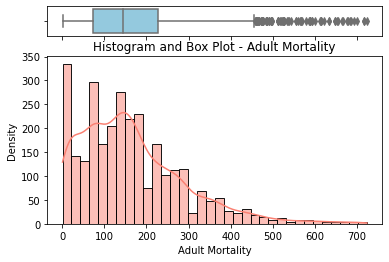

Skewness: 1.176617485446201
Right Skewed 

Kurtosis: 1.7559448291812583
Platykurtic 

JB Test for Normality
1055.3610698189095 0.0
Distribution is not normal 


Histogram and Box Plot - Schooling


<Figure size 720x432 with 0 Axes>

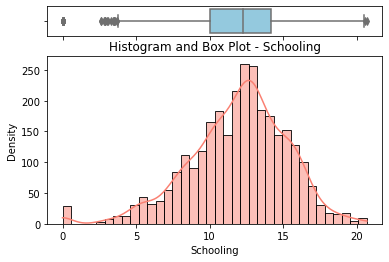

Skewness: -0.5822825739573495
Left Skewed 

Kurtosis: 0.8640001734843632
Platykurtic 

JB Test for Normality
257.4065390407345 0.0
Distribution is not normal 


Histogram and Box Plot - under-five deaths 


<Figure size 720x432 with 0 Axes>

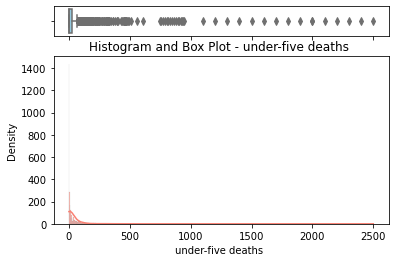

Skewness: 9.490216250784258
Right Skewed 

Kurtosis: 109.56406112014334
Leptokurtic 

JB Test for Normality
1513625.8092590026 0.0
Distribution is not normal 



In [74]:
# Histogram & Box Plot of top 5 most significant numerical features
master(df)
# It uses random forest classifier/regressor to determine important features based on feature importance metric

#### EDA Interpretation:

The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance. These features are HIV/AIDS, Income composition of resources, Adult Mortality, Schooling, and Under-Five Deaths.

##### HIV/AIDS:
This feature specifically focuses on the mortality rate of children aged 0 to 4 years due to HIV/AIDS, measured as the number of deaths per 1000 live births. This feature exhibits a highly right-skewed distribution (skewness: 5.39) with a leptokurtic shape (kurtosis: 34.83), indicating a concentration of lower values with a tail extending towards higher counts. The non-normal distribution is confirmed by the Jarque-Bera test. Despite a mean of 1.74 deaths per 1,000 live births, the wide range (0.1 to 50.60) suggests presence of outliers and extreme values which are evident in the box plot. It is therefore important to consider that the feature's predictive power may be influenced by its skewed nature and outliers and appropriate treatment to address this would be preferred.

##### Income Composition of Resources:
This feature represents Human Development Index in terms of income composition of resources (index ranging from 0 to 1). A higher value indicates a greater share of income resources contributing to human development. This feature exhibits a somewhat left-skewed distribution (skewness: -1.09) with a somewhat leptokurtic shape (kurtosis: 1.31), indicating a concentration of higher values with a tail extending towards lower counts. The non-normal distribution is confirmed by the Jarque-Bera test. The main reason for deviation from normal distribution skewness and kurtosis is the high frequency of minimum value of 0 which is the sole significant outlier as evident from the box plot. Addressing this with appropriate strategy can render this feature extremely useful in capturing true patterns of the life expectancy prediction as the feature depicts similar characters to that of normal distribution except for a singular outlier.

##### Adult Mortality:
This feature represents the probability of dying between the ages of 15 and 60 per 1000 population, for both sexes. This feature exhibits a somewhat right-skewed distribution (skewness: 1.18) with a somewhat leptokurtic shape (kurtosis: 1.76), indicating a concentration of lower values with a tail extending towards higher counts. The non-normal distribution is confirmed by the Jarque-Bera test. Despite a mean of 165 deaths per 1,000 population, the wide range (1 to 723) suggests presence of outliers and extreme values which are evident in the box plot. It is therefore important to consider that the feature's predictive power may be influenced by its skewed nature and outliers and appropriate treatment to address this would be preferred.

##### Schooling:
This feature represents the average number of years of schooling completed by individuals within a population. This feature exhibits a slightly left-skewed distribution (skewness: -0.58) with a slightly leptokurtic shape (kurtosis: 0.86), indicating a concentration of higher values with a tail extending towards lower counts. The non-normal distribution is confirmed by the Jarque-Bera test. The main reason for deviation from normal distribution skewness and kurtosis is the outliers and extreme values towards both ends as evident from the box plot. Trimming ends of this distribution would match its characteristics to that of a normal distribution and can render this feature extremely useful in capturing true patterns of the life expectancy prediction.

##### Under-Five Deaths:
This feature reflects the mortality rate of children under the age of five per 1000 population. This feature exhibits a highly right-skewed distribution (skewness: 9.49) with a highly leptokurtic shape (kurtosis: 109.56), indicating a concentration of lower values with a tail extending towards higher counts. The non-normal distribution is confirmed by the Jarque-Bera test. Despite a mean of 42.04 under-5 deaths per 1,000 populate, the extremely wide range (0 to 2500) suggests presence of outliers and extreme values (especially beyond the upper whisker) which are evident in the box plot. It is therefore important to consider that the feature's predictive power may be highly influenced by its skewed nature and outliers and appropriate treatment to address this would be preferred.

In [75]:
###### Outlier Analysis & Treatment functionality is still under progress!
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 6


'Outlier detection and treatment functionality under progress!'

In [76]:
# Data Transformation
master(df)
# This function first label encode categorical features so that they become numerical (except the target variable)
# Then it uses standard or min-max scaler to standardize all numerical feature (so doesn't apply on target variable)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


### Feature Selection

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 1




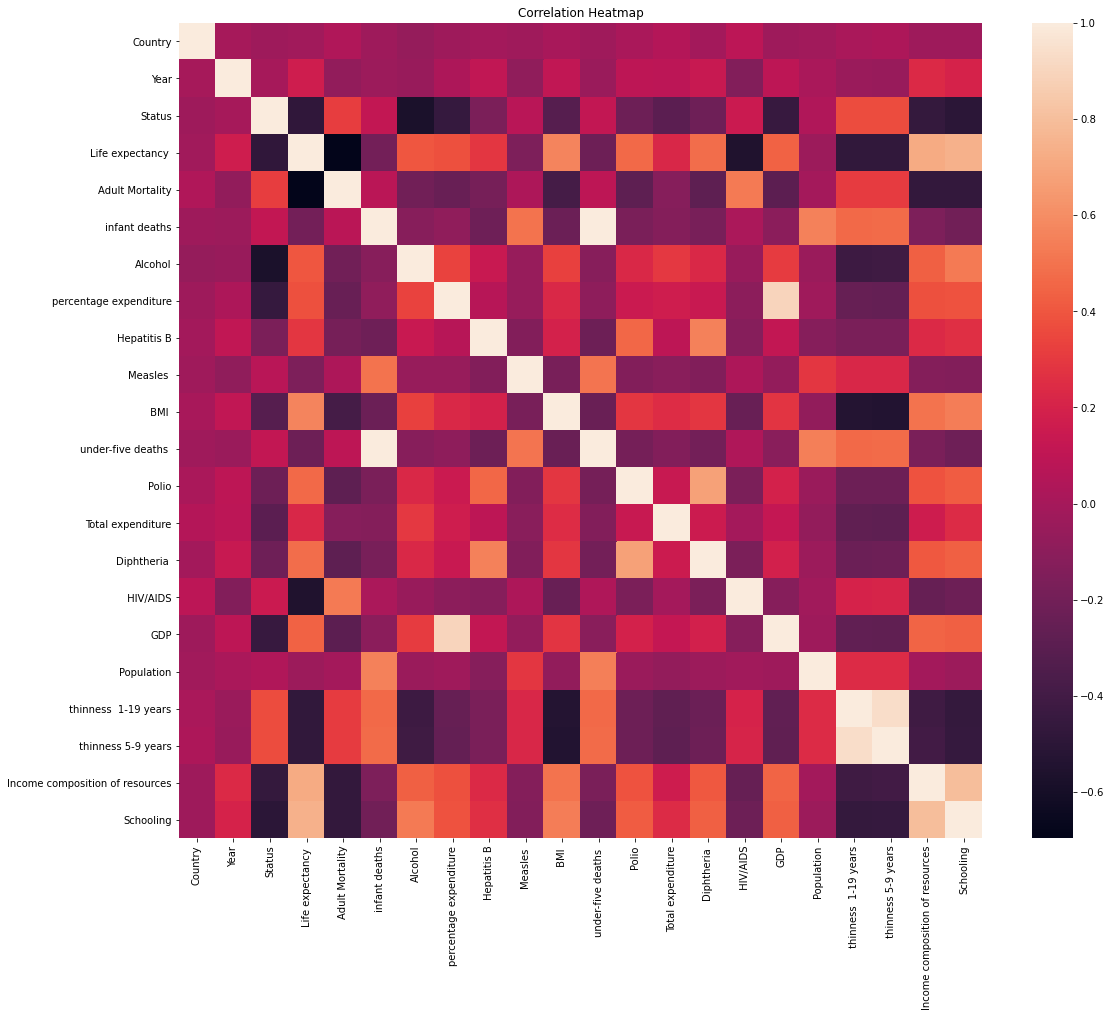


Mutual Information & Correlation of Each Feature with Target Feature
                                 Mutual_Information  Correlation  Variance
Adult Mortality                                1.25         0.70      1.00
Income composition of resources                0.90         0.72      1.00
 thinness 5-9 years                            0.75         0.47      1.00
 thinness  1-19 years                          0.75         0.48      1.00
Schooling                                      0.69         0.75      1.00
 BMI                                           0.58         0.57      1.00
Country                                        0.57         0.02      1.00
 HIV/AIDS                                      0.52         0.56      1.00
infant deaths                                  0.42         0.20      1.00
under-five deaths                              0.41         0.22      1.00
GDP                                            0.37         0.44      1.00
Alcohol                       

In [77]:
# Feature Selection (Filter Methods Approach)
df_filter=master(df)
# Disclaimer: Categorical features were already label encoded in the above step.
# So the correlation heatmap includes all features to aid in filter based feature selection.

#### Comment:
We have selected the features that have the most mutual information and correlation with the Target Feature (Life Expectancy). Mutual information is a measure of dependence between two variables - gauges how much a feature contributes to the prediction of the target variable. For mutual information we’ve determined that the mutual information less than 0.1 translates to weak connection of a feature with target feature. Correlation explains the extent to which two features are linearly related. We’ve determined correlation less than 0.3 translates to low correlation of a feature with target feature. Based on these rules, we’ve omitted the following features:

Year, Population, Measles, Hepatitis B, Total Expenditure, Under-five deaths, Infant deaths, and Country

Income composition of resources and Schooling are highly correlated and so in order to avoid issues of multicollinearity we’ve only selected Income composition of resources as it has higher mutual information metric almost similar correlation with Life Expectancy as of Schooling. Similarly, thinness 5-9 years and thinness 1-19 years are highly correlated so we’ve only selected thinness 1-19 as it has higher mutual information metric and correlation with Life Expectancy and also appeals to logic more.

Multicollinearity increases the model’s variance (resulting in a model where a small change in data or training leads to significant change in model’s learned parameters) and causes overfitting resulting in poor generalization. Moreover, it reduces interpretability as it hampers the ability to interpret individual effects of features on the target variable. Further, for models like OLS, it violates the assumption of linearity.

Note: Variance after standardization is kind of redundant as it has been normalized to 1.

In [78]:
# Feature Selection (Forward Feature Selection Approach)
df_wrapper_fwd=master(df)
# Number of feature parameter is used as a stopping criteria
# Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline
# There's no universal tolerance criteria as it varies for each dataset
# Here number of features are set equal to filter selection number above for better comparison of different methods

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 1

How many features to select? 11

Following are the 11 features selected based on the given feature selector:

Index(['Year', 'Status', 'Adult Mortality', 'percentage expenditure',
       'Diphtheria ', ' HIV/

#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset.

Here number of features are set equal to filter selection number above for better comparison of different methods

In [79]:
# Feature Selection (Backward Feature Selection Approach)
df_wrapper_bck=master(df)
# For number of features same previous logic is applied

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 2

How many features to select? 11

Following are the 11 features selected based on the given feature selector:

Index(['Status', 'Adult Mortality', 'percentage expenditure', 'Hepatitis B',
       'Polio', 'Diph

#### Comment:
For number of features same previous logic is applied.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 3


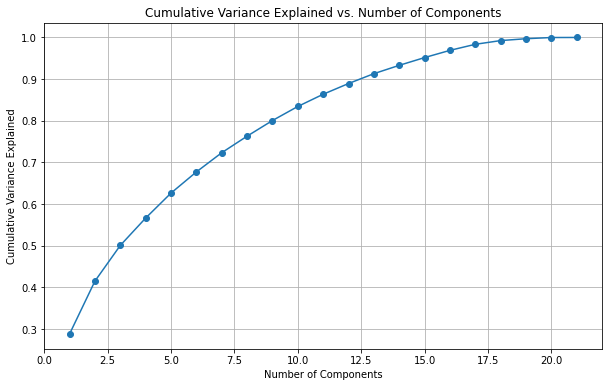


Enter the number of components for PCA: 15


In [80]:
# Dimensionality Reduction (PCA)
df_pca=master(df)

#### Comment:
Since first 15 components explain about 95% variability in the dataset, we've selected first 15 components as feature subset. Increasing the number of components increases cumulative variance but after 15 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor and pareto principal and can lead the model towards overfitting and therefore would be redundant as we're doing feature selection to avoid overfitting.

In [81]:
# Data Splitting
X_train,X_test,y_train,y_test=master(df) # baseline dataset
X_train_fil,X_test_fil,y_train_fil,y_test_fil=master(df_filter) # filter based feature selection dataset
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=master(df_wrapper_fwd) # wrapper (forward) based feature selection dataset
X_train_bck,X_test_bck,y_train_bck,y_test_bck=master(df_wrapper_bck) # wrapper (backward) based feature selection dataset
X_train_pca,X_test_pca,y_train_pca,y_test_pca=master(df_pca) # PCA based feature selection dataset

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 1

What % of data to be left for test? 20
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA 

In [82]:
# Model selection skipped as for this submission our model of choice is fixed (KNN)!

In [83]:
# Model Training
knn=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train)
knn_fil=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil)
knn_fwd=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd)
knn_bck=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck)
knn_pca=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca)
# Number of neighbours is pre-fixed as 5 (No hyperparameter tunning)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression

What is the problem type? 2
What is the value of K? 5
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualiza

In [84]:
# Fetching Results
result=master(knn=knn,X_test=X_test,y_test=y_test) # Returns a DataFrame
result_fil=master(knn=knn_fil,X_test=X_test_fil,y_test=y_test_fil) # Returns a DataFrame
result_fwd=master(knn=knn_fwd,X_test=X_test_fwd,y_test=y_test_fwd) # Returns a DataFrame
result_bck=master(knn=knn_bck,X_test=X_test_bck,y_test=y_test_bck) # Returns a DataFrame
result_pca=master(knn=knn_pca,X_test=X_test_pca,y_test=y_test_pca) # Returns a DataFrame

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression
What is the problem type? 2
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)


In [85]:
# Combined Result
d=[['Baseline', result.iloc[0][0],result.iloc[0][1],result.iloc[0][2]],
   ['Filter Subset', result_fil.iloc[0][0],result_fil.iloc[0][1],result_fil.iloc[0][2]],
   ['FS Subset', result_fwd.iloc[0][0],result_fwd.iloc[0][1],result_fwd.iloc[0][2]],
   ['BS Subset', result_bck.iloc[0][0],result_bck.iloc[0][1],result_bck.iloc[0][2]],
   ['PCA Subset', result_pca.iloc[0][0],result_pca.iloc[0][1],result_pca.iloc[0][2]]]
result_comb2=pd.DataFrame(d,columns=['Subset','R^2 Score','MAE','RMSE'])
result_comb2.sort_values(by=['R^2 Score','MAE','RMSE'], ascending=[False,True,True])

,Subset,R^2 Score,MAE,RMSE
2,FS Subset,0.93,1.57,2.52
1,Filter Subset,0.92,1.67,2.62
0,Baseline,0.92,1.71,2.68
3,BS Subset,0.92,1.73,2.75
4,PCA Subset,0.91,1.87,2.83


#### Result Interpretation:
##### R^2
R^2 determines how much of the variance in the target variable is explained by the features collectively in particular feature subset. In other words, it is a goodness-of-fit measure that measures how well the model has fitted the data. It varies between 0 and 1, with 1 indicating a perfect model fitness (most likely overfit).

##### Mean Absolute Error (MAE)
Mean Absolute Error (MAE) measure the average absolute error between predicted target values from the model and actual target values. It is sensitive to scale so there are no universal bounds like R^2 but the lesser the MAE the better model is performing as it is minimizing the error gap between predicted and actual values, with MAE of 0 indicating a perfect fit (most likely overfit)

##### Root Mean Squared Error (RMSE)
Root Mean Squared Error (RMSE) is another evaluation metric similar to MAE but instead of taking average of absolute differences, average of square root of squared differences is taken. It is also interpreted similarly. Benefit of both MAE and RMSE is that they both are on the same scale as of the actual target variable.

Looking at the combined results above, it is easy to follow that the best feature subset is the one that is taken through forward feature selection methods as it has the highest R^2, and lowest MAE, and RMSE.

---------------------------------------------------------------------------------------------------------------------------

##### Detailed Result (Using Forward Feature Selection Subset)
R^2 of 0.93 indicates a very good model fit to the data. It precisely tells that about 93% variability of the life expectancy feature is explained by our KNN regressor model (or the explanatory features in our forward-based feature selection subset). Since KNN doesn’t have a training phase where model weights are learned, it’s hard to comment whether this value of R^2 indicates an overfit. However, using CV we can compare the model fitness across different subsets of the data to get a more realistic idea and then compare it with our train-test subset to comment whether the model performance on this train-test subset is suggesting overfitting. 

MAE of 1.57 tells us that on average the predicted life expectancy value differences from the actual life expectancy by 1.57 years. Similarly, based on RMSE metric it is estimated that on average the predicted life expectancy value differs from the actual life expectancy by 2.52 years.

### Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)

In [86]:
# Note:For regression problem parameter sk_folds has numerical value of 5 indicating 5 folds
# Previously it had folds as input which was stratifiedkfold and can be used for classification problem
scoresCV=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd,sk_folds=5)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 2

What is the value of K? 5


In [87]:
scoresCV=master(scoresCV=scoresCV)
scoresCV

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 2

Cross-Validation Evaluation
Average CV MAE Score:  2.4047319281334203
Average CV R^2 Score:  0.8776899635901885
Number of CV Scores used in Average:  5


,fit_time,score_time,test_neg_mean_absolute_error,test_r2
0,0.01,0.03,2.58,0.89
1,0.02,0.02,2.52,0.86
2,0.01,0.02,2.34,0.88
3,0.01,0.02,2.27,0.88
4,0.01,0.02,2.31,0.89


In [88]:
da=[["Train-Test Split",result_fwd.iloc[0][0],result_fwd.iloc[0][1]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[3],np.mean(scoresCV)[2]]]
resultCvsNC2=pd.DataFrame(da, columns=['Approach','R^2','MAE'])
resultCvsNC2.sort_values(by=['R^2','MAE'],ascending=[False,True])

,Approach,R^2,MAE
0,Train-Test Split,0.93,1.57
1,Cross-Validation (Avg),0.88,2.40


#### Interpretation:
Cross-validation is used to assess model’s generalizability. While our initial train-test split yielded promising results with an R^2 of 0.93 and MAE of 1.57, cross-validation revealed a slightly lower average R^2 of 0.88 and average MAE of 2.40, indicating that our model might not generalize that well across different subsets of data as it did with the initial train-test subset. However the difference is minor and while our model overfitted on a particular split of a train-test split, it did so only by slightly and regardless provided a good idea of model's performance.

The variations in performance across folds presents a more reliable estimate of the model performance and robustness. Realistically, explanatory features in our model explain between 88% and 89%, 88% on average, variability in the target feature. Similarly, predicted values generate from our model differ from the actual life expectancy by 2.27 to 2.58 years, 2.40 years on average. This performance overall is still regardless a good performance and cross validation helped us find a more realistic performance evaluation of our model.

#  Parkinsons Telemonitoring
source: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

### Data Preprocessing & EDA

In [89]:
# Dataset loading
df,label_column=master()
df.head()

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 1

Please enter the UCI ID 189
Successfuly Connected to the Data Source


,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,total_UPDRS
0,72,5.64,0.01,0.00,0.00,0.00,0.01,0.03,0.23,0.01,...,0.02,0.04,0.01,21.64,0.42,0.55,0.16,0,28.20,34.40
1,72,12.67,0.00,0.00,0.00,0.00,0.00,0.02,0.18,0.01,...,0.02,0.03,0.01,27.18,0.43,0.56,0.11,0,28.45,34.89
2,72,19.68,0.00,0.00,0.00,0.00,0.01,0.02,0.18,0.01,...,0.01,0.02,0.02,23.05,0.46,0.54,0.21,0,28.70,35.39
3,72,25.65,0.01,0.00,0.00,0.00,0.01,0.02,0.33,0.01,...,0.02,0.03,0.03,24.45,0.49,0.58,0.33,0,28.91,35.81
4,72,33.64,0.00,0.00,0.00,0.00,0.00,0.02,0.18,0.01,...,0.02,0.02,0.01,26.13,0.47,0.56,0.19,0,29.19,36.38


In [90]:
# Data Cleaning
master(df)
# This function first checks for duplicate values and drop them
# Then it imputes categorical missing values with modal value
# Afterwards it uses KNN imputer to impute missing values for numerical variables
# Overall it checks what type of cleaning is required (if any) and acts accordingly!

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 2


'Dataset is Already Clean!'

In [91]:
# Summary of Numerical Variables
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 3


,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,total_UPDRS
count,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,...,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00,5875.00
mean,64.80,92.86,0.01,0.00,0.00,0.00,0.01,0.03,0.31,0.02,...,0.03,0.05,0.03,21.68,0.54,0.65,0.22,0.32,21.30,29.02
std,8.82,53.45,0.01,0.00,0.00,0.00,0.01,0.03,0.23,0.01,...,0.02,0.04,0.06,4.29,0.10,0.07,0.09,0.47,8.13,10.70
min,36.00,-4.26,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,...,0.00,0.00,0.00,1.66,0.15,0.51,0.02,0.00,5.04,7.00
25%,58.00,46.85,0.00,0.00,0.00,0.00,0.00,0.02,0.17,0.01,...,0.02,0.03,0.01,19.41,0.47,0.60,0.16,0.00,15.00,21.37
50%,65.00,91.52,0.00,0.00,0.00,0.00,0.01,0.03,0.25,0.01,...,0.02,0.04,0.02,21.92,0.54,0.64,0.21,0.00,20.87,27.58
75%,72.00,138.44,0.01,0.00,0.00,0.00,0.01,0.04,0.36,0.02,...,0.03,0.06,0.03,24.44,0.61,0.71,0.26,1.00,27.60,36.40
max,85.00,215.49,0.10,0.00,0.06,0.07,0.17,0.27,2.11,0.16,...,0.28,0.49,0.75,37.88,0.97,0.87,0.73,1.00,39.51,54.99


1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 5

Histogram and Box Plot - total_UPDRS


<Figure size 720x432 with 0 Axes>

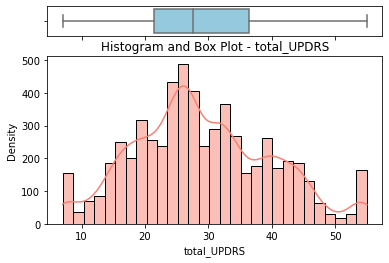

Skewness: 0.27098413559961604
Right Skewed 

Kurtosis: -0.3564219764051635
Platykurtic 

JB Test for Normality
103.00006726983658 0.0
Distribution is not normal 


Histogram and Box Plot - age


<Figure size 720x432 with 0 Axes>

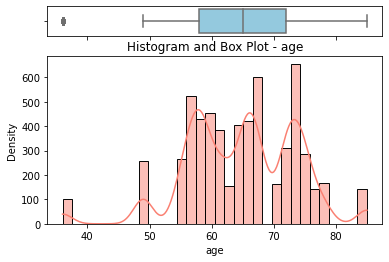

Skewness: -0.3790366177960371
Left Skewed 

Kurtosis: 0.668863669964952
Platykurtic 

JB Test for Normality
250.19021384083814 0.0
Distribution is not normal 


Histogram and Box Plot - test_time


<Figure size 720x432 with 0 Axes>

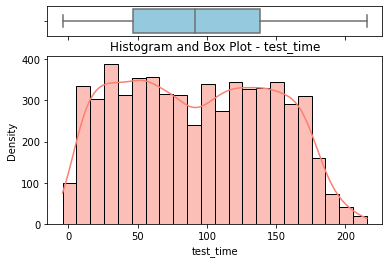

Skewness: 0.07770034559856029
Right Skewed 

Kurtosis: -1.1474220627719964
Platykurtic 

JB Test for Normality
328.19873933928585 0.0
Distribution is not normal 


Histogram and Box Plot - DFA


<Figure size 720x432 with 0 Axes>

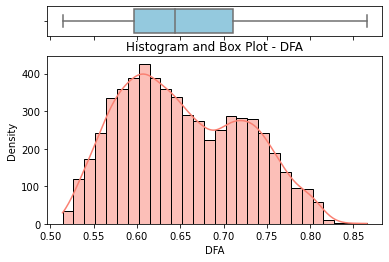

Skewness: 0.28200643480032367
Right Skewed 

Kurtosis: -0.8805177470680889
Platykurtic 

JB Test for Normality
267.66059864020775 0.0
Distribution is not normal 


Histogram and Box Plot - sex


<Figure size 720x432 with 0 Axes>

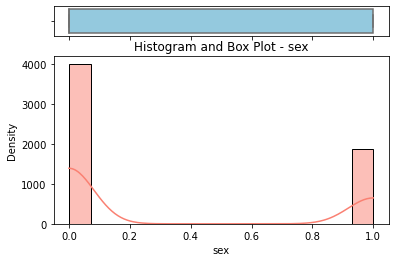

Skewness: 0.7826735401840952
Right Skewed 

Kurtosis: -1.3874221294956948
Platykurtic 

JB Test for Normality
1071.025142860857 0.0
Distribution is not normal 



In [92]:
# Histogram & Box Plot of top 5 most significant numerical features
master(df)

#### EDA Interpretation:
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance. These features are perimeter_worst, concave points_worst, radius_worst, concave points_mean, and area_worst.

##### total_UPDRS: 
It basically indicates the total_UPDRS Score
1. Data is right-skewed with a skewness of 0.271.
2. It exhibits a platykurtic distribution with a kurtosis of -0.356.This indicates that the distribution has lighter tails and a flatter peak compared to a normal distribution.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### Age:
It shows the Age of patient 
1. Data is left-skewed with a skewness of -0.379.
2. It exhibits a platykurtic distribution with a kurtosis of 0.669.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### test-time:
It basically indicates the time of test taken
1. Data is right-skewed with a skewness of 0.078.
2. It exhibits a platykurtic distribution with a kurtosis of -1.147.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
##### DFA:
DFA is a scaling exponent α-DFA which informs about the statistical nature of fluctuations
1. Data is right-skewed with a skewness of 0.282.
2. It exhibits a platykurtic distribution with a kurtosis of -0.881.
3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

In [93]:
# Outlier Analysis & Treatment functionality is still under progress!
master(df)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 6


'Outlier detection and treatment functionality under progress!'

In [94]:
# Data Transformation
master(df)
# This function first label encode categorical features so that they become numerical (except the target variable)
# Then it uses standard or min-max scaler to standardize all numerical feature (so doesn't apply on target variable)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


### Feature Selection

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 1




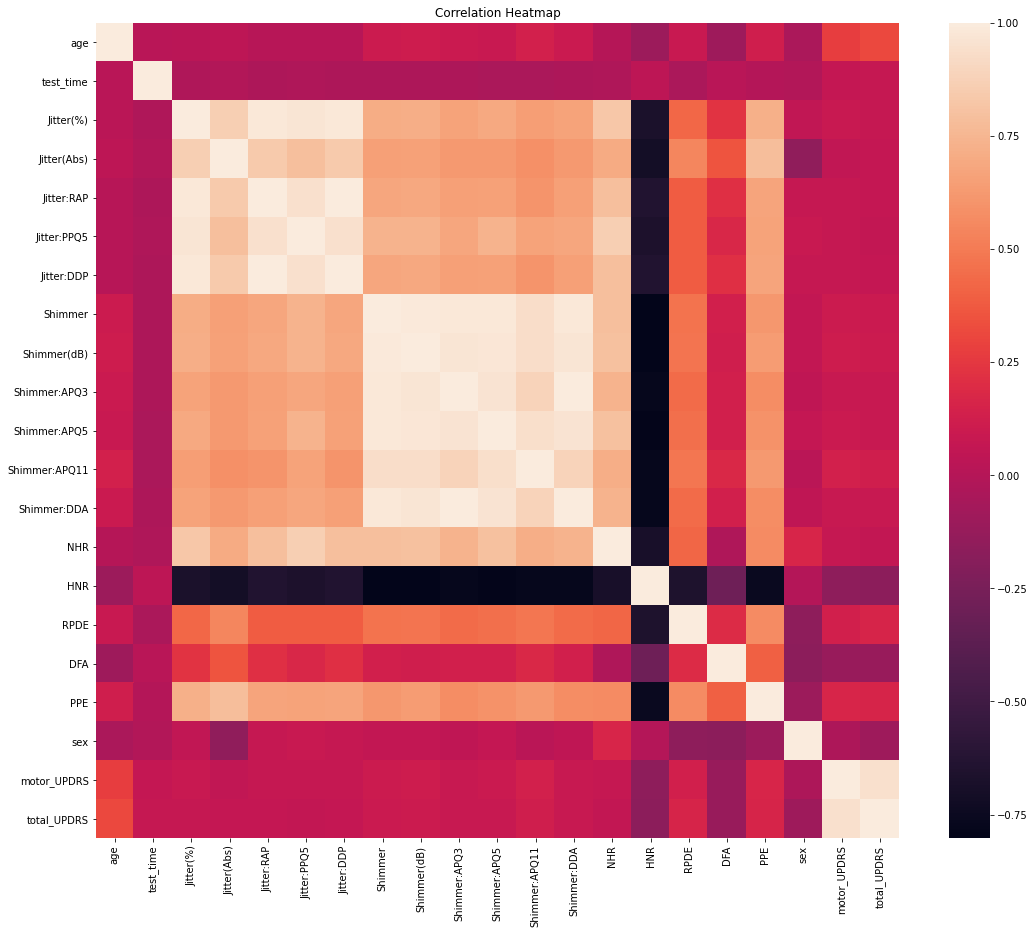


Mutual Information & Correlation of Each Feature with Target Feature
               Mutual_Information  Correlation  Variance
total_UPDRS                  5.42         0.95      1.00
test_time                    5.29         0.07      1.00
age                          3.00         0.27      1.00
sex                          0.61         0.03      1.00
DFA                          0.20         0.12      1.00
HNR                          0.13         0.16      1.00
Jitter(Abs)                  0.11         0.05      1.00
Shimmer:APQ11                0.10         0.14      1.00
Jitter(%)                    0.10         0.08      1.00
Shimmer:APQ3                 0.10         0.08      1.00
Jitter:PPQ5                  0.10         0.08      1.00
Shimmer:DDA                  0.10         0.08      1.00
PPE                          0.09         0.16      1.00
Shimmer                      0.09         0.10      1.00
NHR                          0.09         0.07      1.00
Shimmer:APQ5      

In [95]:
# Feature Selection (Filter Methods Approach)
df_filter=master(df)
# Disclaimer: Categorical features were already label encoded in the above step.
# So the correlation heatmap includes all features to aid in filter based feature selection.

#### Comment:
Selected 10 features are based on the mutual information (above 0.1) Or correlation (0.12). If not gone to extreme to select such values model might get underfit.

In [96]:
# Feature Selection (Forward Feature Selection Approach)
df_wrapper_fwd=master(df)
# Number of feature parameter is used as a stopping criteria
# Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline
# There's no universal tolerance criteria as it varies for each dataset
# Here number of features are set equal to filter selection number above for better comparison of different methods

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 1

How many features to select? 10

Following are the 10 features selected based on the given feature selector:

Index(['age', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'NHR',

#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset.

Here number of features are set equal to filter selection number above for better comparison of different methods

In [97]:
# Feature Selection (Backward Feature Selection Approach)
df_wrapper_bck=master(df)
# For number of features same previous logic is applied

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 2

1- Forward Selection
2- Backward Selection
3- No Recursive Feature Selection (Since KNN has no Feature Importance Metric)
Which feature selection method to select? 2

How many features to select? 10

Following are the 10 features selected based on the given feature selector:

Index(['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'S

#### Comment:
For number of features same previous logic is applied.

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 8

1- Filter Methods
2- Wrapper Methods
3- Dimensionality Reduction (PCA)
Which type of method? 3


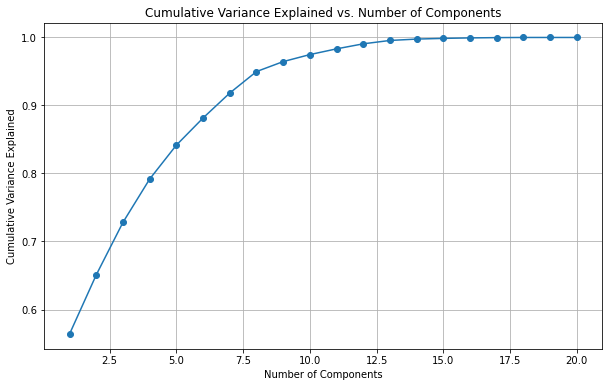


Enter the number of components for PCA: 8


In [98]:
# Dimensionality Reduction (PCA)
df_pca=master(df)

#### Comment:
Since first 8 components explain about 95% variability in the dataset, we've selected first 8 components as feature subset. Increasing the number of components increases cumulative variance but after 8 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor and pareto principal and can lead the model towards overfitting and therefore would be redundant as we're doing feature selection to avoid overfitting.

In [99]:
# Data Splitting
X_train,X_test,y_train,y_test=master(df) # baseline dataset
X_train_fil,X_test_fil,y_train_fil,y_test_fil=master(df_filter) # filter based feature selection dataset
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=master(df_wrapper_fwd) # wrapper (forward) based feature selection dataset
X_train_bck,X_test_bck,y_train_bck,y_test_bck=master(df_wrapper_bck) # wrapper (backward) based feature selection dataset
X_train_pca,X_test_pca,y_train_pca,y_test_pca=master(df_pca) # PCA based feature selection dataset

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 10

1- Train-Test Split
2- Stratified Cross-Validation (Classification Only)
What is the requirement? 1

What % of data to be left for test? 20
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA 

In [100]:
# Model selection skipped as for this submission our model of choice is fixed (KNN)!

In [101]:
# Model Training
knn=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train)
knn_fil=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil)
knn_fwd=master(data=df_wrapper_fwd,X_train=X_train_fwd, X_test=X_test_fwd, y_train=y_train_fwd)
knn_bck=master(data=df_wrapper_bck,X_train=X_train_bck, X_test=X_test_bck, y_train=y_train_bck)
knn_pca=master(data=df_pca,X_train=X_train_pca, X_test=X_test_pca, y_train=y_train_pca)
# Number of neighbours is pre-fixed as 5 (No hyperparameter tunning)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression

What is the problem type? 2
What is the value of K? 5
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualiza

In [102]:
# Fetching Results
result=master(knn=knn,X_test=X_test,y_test=y_test) # Returns a DataFrame
result_fil=master(knn=knn_fil,X_test=X_test_fil,y_test=y_test_fil) # Returns a DataFrame
result_fwd=master(knn=knn_fwd,X_test=X_test_fwd,y_test=y_test_fwd) # Returns a DataFrame
result_bck=master(knn=knn_bck,X_test=X_test_bck,y_test=y_test_bck) # Returns a DataFrame
result_pca=master(knn=knn_pca,X_test=X_test_pca,y_test=y_test_pca) # Returns a DataFrame

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 1

1- Classification
2- Regression
What is the problem type? 2
1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)


In [103]:
# Combined Result
d=[['Baseline', result.iloc[0][0],result.iloc[0][1],result.iloc[0][2]],
   ['Filter Subset', result_fil.iloc[0][0],result_fil.iloc[0][1],result_fil.iloc[0][2]],
   ['FS Subset', result_fwd.iloc[0][0],result_fwd.iloc[0][1],result_fwd.iloc[0][2]],
   ['BS Subset', result_bck.iloc[0][0],result_bck.iloc[0][1],result_bck.iloc[0][2]],
   ['PCA Subset', result_pca.iloc[0][0],result_pca.iloc[0][1],result_pca.iloc[0][2]]]
result_comb5=pd.DataFrame(d,columns=['Subset','R^2 Score','MAE','RMSE'])
result_comb5.sort_values(by=['R^2 Score','MAE','RMSE'], ascending=[False,True,True])

,Subset,R^2 Score,MAE,RMSE
1,Filter Subset,0.98,0.68,1.10
2,FS Subset,0.97,1.01,1.44
4,PCA Subset,0.96,0.94,1.54
0,Baseline,0.96,0.93,1.55
3,BS Subset,0.94,1.50,2.09


#### Result Interpretation:
##### R^2
R^2 determines how much of the variance in the target variable is explained by the features collectively in particular feature subset. In other words, it is a goodness-of-fit measure that measures how well the model has fitted the data. It varies between 0 and 1, with 1 indicating a perfect model fitness (most likely overfit).

##### Mean Absolute Error (MAE)
Mean Absolute Error (MAE) measure the average absolute error between predicted target values from the model and actual target values. It is sensitive to scale so there are no universal bounds like R^2 but the lesser the MAE the better model is performing as it is minimizing the error gap between predicted and actual values, with MAE of 0 indicating a perfect fit (most likely overfit)

##### Root Mean Squared Error (RMSE)
Root Mean Squared Error (RMSE) is another evaluation metric similar to MAE but instead of taking average of absolute differences, average of square root of squared differences is taken. It is also interpreted similarly. Benefit of both MAE and RMSE is that they both are on the same scale as of the actual target variable.

Looking at the combined results above, it is easy to follow that the best feature subset is the one that is taken through forward feature selection methods as it has the highest R^2, and lowest MAE, and RMSE.

---------------------------------------------------------------------------------------------------------------------------

##### Detailed Result (Using Filter Based Feature Selection Subset)
R^2 of 0.98 indicates a very good model fit to the data. It precisely tells that about 98% variability of the life expectancy feature is explained by our KNN regressor model (or the explanatory features in our forward-based feature selection subset). Since KNN doesn’t have a training phase where model weights are learned, it’s hard to comment whether this value of R^2 indicates an overfit. However, using CV we can compare the model fitness across different subsets of the data to get a more realistic idea and then compare it with our train-test subset to comment whether the model performance on this train-test subset is suggesting overfitting.

MAE of 0.68 tells us that on average the predicted motor_UPDRS value differences from the actual motor_UPDRS by 0.68 score. Similarly, based on RMSE metric it is estimated that on average the predicted motor_UPDRS value differs from the actual motor_UPDRS by 1.10 Score.

### Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)

In [104]:
# Note:For regression problem parameter sk_folds has numerical value of 5 indicating 5 folds
# Previously it had folds as input which was stratifiedkfold and can be used for classification problem
scoresCV=master(data=df_filter,X_train=X_train_fil, X_test=X_test_fil, y_train=y_train_fil,sk_folds=5)

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 12

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 2

What is the value of K? 5


In [105]:
scoresCV=master(scoresCV=scoresCV)
scoresCV

1- Fetch Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Numerical Summary
4- EDA: Class Balance(%) (Classification Only)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Outliers Detection & Treatment
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9- PCA Visualization (Classification Only)
10-  Data Splitting & Cross-Validation
11- Model Selection
12- Model Training(KNN)
13- Model Evaluation
14- More Functions to be Added

What do you want to do? 13

1- Non-CV
2- CV
What is the requirement? 2

1- Classification
2- Regression
What is the problem type? 2

Cross-Validation Evaluation
Average CV MAE Score:  3.539707245828425
Average CV R^2 Score:  0.5480835464874341
Number of CV Scores used in Average:  5


,fit_time,score_time,test_neg_mean_absolute_error,test_r2
0,0.01,0.07,3.09,0.73
1,0.01,0.07,3.70,0.19
2,0.01,0.06,3.12,0.78
3,0.01,0.09,4.29,0.43
4,0.01,0.07,3.49,0.61


In [106]:
da=[["Train-Test Split",result_fil.iloc[0][0],result_fil.iloc[0][1]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[3],np.mean(scoresCV)[2]]]
resultCvsNC5=pd.DataFrame(da, columns=['Approach','R^2','MAE'])
resultCvsNC5.sort_values(by=['R^2','MAE'],ascending=[False,True])

,Approach,R^2,MAE
0,Train-Test Split,0.98,0.68
1,Cross-Validation (Avg),0.55,3.54


#### Interpretation:
Cross-validation is used to assess model’s generalizability. While our initial train-test split yielded promising results with an R^2 of 0.98 and MAE of 0.68, cross-validation revealed a very lower average R^2 of 0.55 and average MAE of 3.54, indicating that our model is not generalized that well across different subsets of data as it did with the initial train-test subset.
Hence it can be inferred that our model overfitted for the selected features in train-test split, showing bad performance of model in cross-validation.

# Combined Results

In [107]:
print("Classification Datasets")
print("-------------------------------------------------------------------------------------------"
      +"------------------------------------","\n")
print("Dataset # 1 : Breast Cancer Wisconsin (Diagnostic)","\n")
print(tabulate(result_comb1.sort_values(by=['Testing Accuracy','AUC'], ascending=False),headers='keys',tablefmt='psql'),"\n")
print(tabulate(resultCvsNC1.sort_values(by=['Testing Accuracy Score','ROC-AUC Score'],ascending=False),headers='keys',
               tablefmt='psql'),"\n\n\n")
print("Dataset # 2 : Congressional Voting Records","\n")
print(tabulate(result_comb3.sort_values(by=['Testing Accuracy','AUC'], ascending=False),headers='keys',tablefmt='psql'),"\n")
print(tabulate(resultCvsNC3.sort_values(by=['Testing Accuracy Score','ROC-AUC Score'],ascending=False),headers='keys',
               tablefmt='psql'),"\n\n\n")
print("Dataset # 3 : Predict Students' Dropout and Academic Success","\n")
print(tabulate(result_comb4.sort_values(by=['Testing Accuracy'], ascending=False),headers='keys',tablefmt='psql'),"\n")
print(tabulate(resultCvsNC4.sort_values(by=['Testing Accuracy Score'],ascending=False),headers='keys',tablefmt='psql'))
print("-------------------------------------------------------------------------------------------"
      +"------------------------------------","\n\n\n")
print("Regression Datasets")
print("-------------------------------------------------------------------------------------------"
      +"------------------------------------","\n")
print("Dataset # 4 : Life Expectancy (WHO)","\n")
print(tabulate(result_comb2.sort_values(by=['R^2 Score','MAE','RMSE'], ascending=[False,True,True]),headers='keys',
               tablefmt='psql'),"\n")
print(tabulate(resultCvsNC2.sort_values(by=['R^2','MAE'],ascending=[False,True]),headers='keys',tablefmt='psql'),"\n\n\n")
print("Dataset # 5 : Parkinsons Telemonitoring","\n")
print(tabulate(result_comb5.sort_values(by=['R^2 Score','MAE','RMSE'], ascending=[False,True,True]),headers='keys',
               tablefmt='psql'),"\n")
print(tabulate(resultCvsNC5.sort_values(by=['R^2','MAE'],ascending=[False,True]),headers='keys',tablefmt='psql'))

Classification Datasets
------------------------------------------------------------------------------------------------------------------------------- 

Dataset # 1 : Breast Cancer Wisconsin (Diagnostic) 

+----+---------------+--------------------+----------+
|    | Subset        |   Testing Accuracy |      AUC |
|----+---------------+--------------------+----------|
|  4 | PCA Subset    |           0.982456 | 0.986301 |
|  0 | Baseline      |           0.982456 | 0.9858   |
|  1 | Filter Subset |           0.973684 | 0.983127 |
|  2 | FS Subset     |           0.964912 | 0.985299 |
|  3 | BS Subset     |           0.964912 | 0.970431 |
+----+---------------+--------------------+----------+ 

+----+------------------------+--------------------------+-----------------+
|    | Approach               |   Testing Accuracy Score |   ROC-AUC Score |
|----+------------------------+--------------------------+-----------------|
|  0 | Train-Test Split       |                 0.982456 |       

#### Interpretation:
These results reveal that there’s no universally best method for feature selection as the performance of feature selection methods varies across different datasets. For instance, for classification datasets sometimes backward feature selection renders the best performance and at times renders the worst performance. Similarly, problem type (classification and regression) doesn’t influence the feature selection method as for one regression datasets filter based approach is the preferred choice whereas for the other regression dataset forward feature selection is preferred but at the same time forward feature selection also render good results for classification datasets.

It's interesting to note that for some datasets baseline approach where no feature selection is done offers higher performance than some of the feature selection approaches. One possible reason could be that the model with baseline approach is overfitting as it has included all the features and made a highly complex model.

The best performing feature subset on train-test split is used for comparison with CV scores (which provide a more realistic performance measure of the model) to determine model’s generalizability and in 4 out of 5 instances model is highly generalizable. In dataset 2 model slightly underfits on the initial train-test split in comparison to CV score suggesting that it could be optimized further for better performance. Dataset 5 is an anomaly where the best performing subset highly overfits the initial train-test split when compared with average CV scores. The plan of action in this instance would be to go for the next best performing feature subset until the model generalizes well. If all feature subsets fail to generalize then the suggestion would be to reconfigure data preprocessing and feature selection again and if all fails then changing the model or data sample would be recommended.

# OLS Regression Implementation (Life Expectancy (WHO))

In [108]:
# Data Preprocessing & EDA
df=pd.read_csv("Regression.Life.Expectancy.csv")
label_column='Life expectancy '

# Cleaning Missing & Duplicate Values (if any)
if df.isnull().values.any() & df.duplicated().any():
    duplicate_value_treatment(df)
    missing_value_treatment(df)
elif df.isnull().values.any():
    missing_value_treatment(df)
elif df.duplicated().any():
    duplicate_value_treatment(df)

# EDA skipped as done previously with KNN implementation

# Data Transformation
cat_encoding(df)
data_standardization(df,1)

Dataset is treated for missing values successfully


In [109]:
# Feature Selection
# Filter based & PCA subset would remain the same
# However, foward & backward feature selection subset would change.
# As the model has changed on which we evaluated the performance of features (from KNN to OLS)

df_filter=df[['Adult Mortality', 'Income composition of resources', ' thinness  1-19 years', ' BMI ',
               ' HIV/AIDS', 'GDP', 'Alcohol', 'Polio', 'Diphtheria ', 'percentage expenditure', 'Status',label_column]]

pca = PCA(n_components=15)
pca_df=pca.fit_transform(df.drop([label_column],axis=1))
pca_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(15)])
pca_df[label_column]=df[label_column]
df_pca=pca_df

X=df.drop([label_column],axis=1)
Y=df[label_column]
model=LinearRegression().fit(X, Y)
selector=SequentialFeatureSelector(model, n_features_to_select=11, direction="forward")
selector.fit(df.drop([label_column],axis=1), df[label_column])
selected_indices=selector.support_
wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
wrapper_df[label_column]=df[label_column]
df_wrapper_fwd=wrapper_df
    
selector=SequentialFeatureSelector(model, n_features_to_select=11, direction="backward")
selector.fit(df.drop([label_column],axis=1), df[label_column])
selected_indices=selector.support_
wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
wrapper_df[label_column]=df[label_column]
df_wrapper_bck=wrapper_df

In [110]:
# Data Splitting
X_train,X_test,y_train,y_test=data_split(df)
X_train_fil,X_test_fil,y_train_fil,y_test_fil=data_split(df_filter)
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=data_split(df_wrapper_fwd)
X_train_bck,X_test_bck,y_train_bck,y_test_bck=data_split(df_wrapper_bck)
X_train_pca,X_test_pca,y_train_pca,y_test_pca=data_split(df_pca)

# Model Training
X=X_train; Y=y_train; X=sm.add_constant(X); ols=sm.OLS(Y,X)
X=X_train_fil; Y=y_train_fil; X=sm.add_constant(X); ols_fil=sm.OLS(Y,X)
X=X_train_fwd; Y=y_train_fwd; X=sm.add_constant(X); ols_fwd=sm.OLS(Y,X)
X=X_train_bck; Y=y_train_bck; X=sm.add_constant(X); ols_bck=sm.OLS(Y,X)
X=X_train_pca; Y=y_train_pca; X=sm.add_constant(X); ols_pca=sm.OLS(Y,X)

# Model Results
results=ols.fit()
X_test=sm.add_constant(X_test); y_pred=results.predict(X_test)
r_squared=results.rsquared
mae=mean_absolute_error(y_test, y_pred); mse=mean_squared_error(y_test, y_pred); rmse=np.sqrt(mse)
aic=results.aic; bic=results.bic; f_test_p_value=results.f_pvalue

results_fil=ols_fil.fit()
X_test_fil=sm.add_constant(X_test_fil); y_pred_fil=results_fil.predict(X_test_fil)
r_squared_fil=results_fil.rsquared
mae_fil=mean_absolute_error(y_test_fil, y_pred_fil); mse_fil=mean_squared_error(y_test_fil, y_pred_fil)
rmse_fil=np.sqrt(mse_fil)
aic_fil=results_fil.aic; bic_fil=results_fil.bic; f_test_p_value_fil=results_fil.f_pvalue

results_fwd=ols_fwd.fit()
X_test_fwd=sm.add_constant(X_test_fwd); y_pred_fwd=results_fwd.predict(X_test_fwd)
r_squared_fwd=results_fwd.rsquared
mae_fwd=mean_absolute_error(y_test_fwd, y_pred_fwd); mse_fwd=mean_squared_error(y_test_fwd, y_pred_fwd)
rmse_fwd=np.sqrt(mse_fwd)
aic_fwd=results_fwd.aic; bic_fwd=results_fwd.bic; f_test_p_value_fwd=results_fwd.f_pvalue

results_bck=ols_bck.fit()
X_test_bck=sm.add_constant(X_test_bck); y_pred_bck=results_bck.predict(X_test_bck)
r_squared_bck=results_bck.rsquared
mae_bck=mean_absolute_error(y_test_bck, y_pred_bck); mse_bck=mean_squared_error(y_test_bck, y_pred_bck)
rmse_bck=np.sqrt(mse_bck)
aic_bck=results_bck.aic; bic_bck=results_bck.bic; f_test_p_value_bck=results_bck.f_pvalue

results_pca=ols_pca.fit()
X_test_pca=sm.add_constant(X_test_pca); y_pred_pca=results_pca.predict(X_test_pca)
r_squared_pca=results_pca.rsquared
mae_pca=mean_absolute_error(y_test_pca, y_pred_pca); mse_pca=mean_squared_error(y_test_pca, y_pred_pca)
rmse_pca=np.sqrt(mse_pca)
aic_pca=results_pca.aic; bic_pca=results_pca.bic; f_test_p_value_pca=results_pca.f_pvalue

subset_names=['Baseline', 'Filter', 'Forward', 'Backward', 'PCA']
metrics={
    'mse': [mse, mse_fil, mse_fwd, mse_bck, mse_pca],
    'mae': [mae, mae_fil, mae_fwd, mae_bck, mae_pca],
    'rmse': [rmse, rmse_fil, rmse_fwd, rmse_bck, rmse_pca],
    'r_squared': [r_squared, r_squared_fil, r_squared_fwd, r_squared_bck, r_squared_pca],
    'aic': [aic, aic_fil, aic_fwd, aic_bck, aic_pca],
    'bic': [bic, bic_fil, bic_fwd, bic_bck, bic_pca],
    'p_value': [f_test_p_value, f_test_p_value_fil, f_test_p_value_fwd, f_test_p_value_bck, f_test_p_value_pca]
}
metrics_df=pd.DataFrame(metrics, index=subset_names)
metrics_df.sort_values(by=['r_squared', 'mse', 'mae', 'rmse', 'aic', 'bic'], 
                        ascending=[False, True, True, True, True, True])


What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20


,mse,mae,rmse,r_squared,aic,bic,p_value
Baseline,15.29,2.98,3.91,0.83,13140.44,13267.21,0.00
Backward,15.95,3.01,3.99,0.83,13186.79,13255.94,0.00
Forward,16.26,3.06,4.03,0.82,13269.24,13338.38,0.00
PCA,16.22,3.04,4.03,0.82,13296.91,13389.10,0.00
Filter,17.74,3.11,4.21,0.80,13539.47,13608.62,0.00


In [111]:
# Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)
X=df_wrapper_bck.drop([label_column],axis=1)
Y=df_wrapper_bck[label_column]
model=LinearRegression().fit(X, Y)
scoresCV=cross_validate(model,df_wrapper_bck.drop([label_column],axis=1), df_wrapper_bck[label_column],cv=5,
                       scoring=['r2','neg_median_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'])
scoresCV=pd.DataFrame(scoresCV)
scoresCV['R2']=scoresCV['test_r2']
scoresCV['MAE']=np.abs(scoresCV['test_neg_median_absolute_error'])
scoresCV['MSE']=np.abs(scoresCV['test_neg_mean_squared_error'])
scoresCV['RMSE']=np.abs(scoresCV['test_neg_root_mean_squared_error'])
scoresCV.drop(columns=['test_r2','test_neg_median_absolute_error','test_neg_mean_squared_error',
                      'test_neg_root_mean_squared_error'], inplace=True)
scoresCV
print("")
print(f"Average R2: {np.mean(scoresCV['R2'])}")
print(f"Average MAE: {np.mean(scoresCV['MAE'])}")
print(f"Average MSE: {np.mean(scoresCV['MSE'])}")
print(f"Average RMSE: {np.mean(scoresCV['RMSE'])}")
print("Number of CV Scores used in Average:  5")


Average R2: 0.8080746722766268
Average MAE: 2.318454204381227
Average MSE: 17.12444203784402
Average RMSE: 4.13311732436325
Number of CV Scores used in Average:  5


# Logistic Regression Implementation (Breast Cancer Wisconsin)

In [112]:
# Data Preprocessing & EDA
df=pd.read_csv("Classification.CancerMB.csv")
label_column='diagnosis'

# Manually drop redundant columns
df=df.drop(["id"],axis=1)
df=df.drop(["Unnamed: 32"],axis=1)

# Cleaning Missing & Duplicate Values (if any)
if df.isnull().values.any() & df.duplicated().any():
    duplicate_value_treatment(df)
    missing_value_treatment(df)
elif df.isnull().values.any():
    missing_value_treatment(df)
elif df.duplicated().any():
    duplicate_value_treatment(df)

# EDA skipped as done previously with KNN implementation

# Data Transformation
cat_encoding(df)
data_standardization(df,1)

In [113]:
# Feature Selection
# Filter based & PCA subset would remain the same
# However, foward & backward feature selection subset would change.
# As the model has changed on which we evaluated the performance of features (from KNN to logistic Regression)

df_filter=df[['perimeter_worst', 'concave points_worst', 'concavity_worst', 'perimeter_se', 'compactness_worst',
              'compactness_mean', 'concave points_se', 'texture_worst', 'texture_mean',label_column]]

pca = PCA(n_components=9)
pca_df=pca.fit_transform(df.drop([label_column],axis=1))
pca_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(9)])
pca_df[label_column]=df[label_column]
df_pca=pca_df

X=df.drop([label_column],axis=1)
Y=df[label_column]
model=LogisticRegression(random_state=123).fit(X, Y)
selector=SequentialFeatureSelector(model, n_features_to_select=9, direction="forward")
selector.fit(df.drop([label_column],axis=1), df[label_column])
selected_indices=selector.support_
wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
wrapper_df[label_column]=df[label_column]
df_wrapper_fwd=wrapper_df
    
selector=SequentialFeatureSelector(model, n_features_to_select=9, direction="backward")
selector.fit(df.drop([label_column],axis=1), df[label_column])
selected_indices=selector.support_
wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
wrapper_df[label_column]=df[label_column]
df_wrapper_bck=wrapper_df

In [114]:
# Data Splitting
X_train,X_test,y_train,y_test=data_split(df)
X_train_fil,X_test_fil,y_train_fil,y_test_fil=data_split(df_filter)
X_train_fwd,X_test_fwd,y_train_fwd,y_test_fwd=data_split(df_wrapper_fwd)
X_train_bck,X_test_bck,y_train_bck,y_test_bck=data_split(df_wrapper_bck)
X_train_pca,X_test_pca,y_train_pca,y_test_pca=data_split(df_pca)

# Model Training
X=X_train; Y=y_train; lr=LogisticRegression(random_state=123).fit(X, Y)
X=X_train_fil; Y=y_train_fil; lr_fil=LogisticRegression(random_state=123).fit(X, Y)
X=X_train_fwd; Y=y_train_fwd; lr_fwd=LogisticRegression(random_state=123).fit(X, Y)
X=X_train_bck; Y=y_train_bck; lr_bck=LogisticRegression(random_state=123).fit(X, Y)
X=X_train_pca; Y=y_train_pca; lr_pca=LogisticRegression(random_state=123).fit(X, Y)

# Model Results
def lr_results(model,X_test,y_test):
    y_prob=model.predict_proba(X_test)
    y_pred_test=model.predict(X_test)
    auc=roc_auc_score(y_test, y_prob[:, 1])
    class_report=classification_report(y_test,y_pred_test,output_dict=True,target_names=df[label_column].unique().tolist())
    df_report=pd.DataFrame(class_report).transpose()
    df_report1=df_report.iloc[0:2]
    df_report2=df_report1.append(pd.Series({'precision': '---','recall': '---','f1-score': '---','support': '---'},
                                       name='---'))
    df_report2=df_report2.append((df_report.iloc[-3:]).iloc[0:1])
    df_report=df_report2.append(pd.Series({'precision': auc,'recall': auc,'f1-score': auc,'support': auc}, name='AUC'))
    return df_report

result=lr_results(model=lr,X_test=X_test,y_test=y_test)
result_fil=lr_results(model=lr_fil,X_test=X_test_fil,y_test=y_test_fil)
result_fwd=lr_results(model=lr_fwd,X_test=X_test_fwd,y_test=y_test_fwd)
result_bck=lr_results(model=lr_bck,X_test=X_test_bck,y_test=y_test_bck)
result_pca=lr_results(model=lr_pca,X_test=X_test_pca,y_test=y_test_pca)

d=[['Baseline', result.iloc[3][0],result.iloc[4][0]], ['Filter Subset', result_fil.iloc[3][0], result_fil.iloc[4][0]],
   ['FS Subset', result_fwd.iloc[3][0],result_fwd.iloc[4][0]], ['BS Subset', result_bck.iloc[3][0],result_bck.iloc[4][0]],
   ['PCA Subset', result_pca.iloc[3][0],result_pca.iloc[4][0]]]
result_comb=pd.DataFrame(d,columns=['Subset','Testing Accuracy','AUC'])
result_comb.sort_values(by=['Testing Accuracy','AUC'], ascending=False)


What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20

What % of data to be left for test? 20


,Subset,Testing Accuracy,AUC
0,Baseline,0.99,0.99
3,BS Subset,0.99,0.99
4,PCA Subset,0.99,0.99
2,FS Subset,0.97,0.98
1,Filter Subset,0.96,0.99


In [115]:
# Detailed Result of the best subset
result_bck

,precision,recall,f1-score,support
M,0.99,1.00,0.99,73.00
B,1.00,0.98,0.99,41.00
---,---,---,---,---
accuracy,0.99,0.99,0.99,0.99
AUC,0.99,0.99,0.99,0.99


In [116]:
# Cross Validation vs. Train-Test Split (Holding Feature Selection Constant)
folds=cross_val(df_wrapper_bck)
X=df_wrapper_bck.drop([label_column],axis=1)
Y=df_wrapper_bck[label_column]
model=LogisticRegression(random_state=123).fit(X, Y)
scoresCV=cross_validate(model, df_wrapper_bck.drop([label_column],axis=1),df_wrapper_bck[label_column],
                        scoring=['accuracy','roc_auc'],cv=folds)
scoresCV=pd.DataFrame(scoresCV)
da=[["Train-Test Split",result_bck.iloc[3][0],result_bck.iloc[4][0]],
    ["Cross-Validation (Avg)",np.mean(scoresCV)[2],np.mean(scoresCV)[3]]]
resultCvsNC=pd.DataFrame(da, columns=['Approach','Testing Accuracy Score', 'ROC-AUC Score'])
resultCvsNC.sort_values(by=['Testing Accuracy Score','ROC-AUC Score'],ascending=False)


How many folds required? 5


,Approach,Testing Accuracy Score,ROC-AUC Score
0,Train-Test Split,0.99,0.99
1,Cross-Validation (Avg),0.98,1.00
